In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib qt
# %matplotlib osx


sns.set_style("whitegrid")
sns.set_style("ticks")
from datetime import datetime
str(datetime.now())

# sns.set_palette('colorblind')


'2018-10-16 10:47:47.570555'

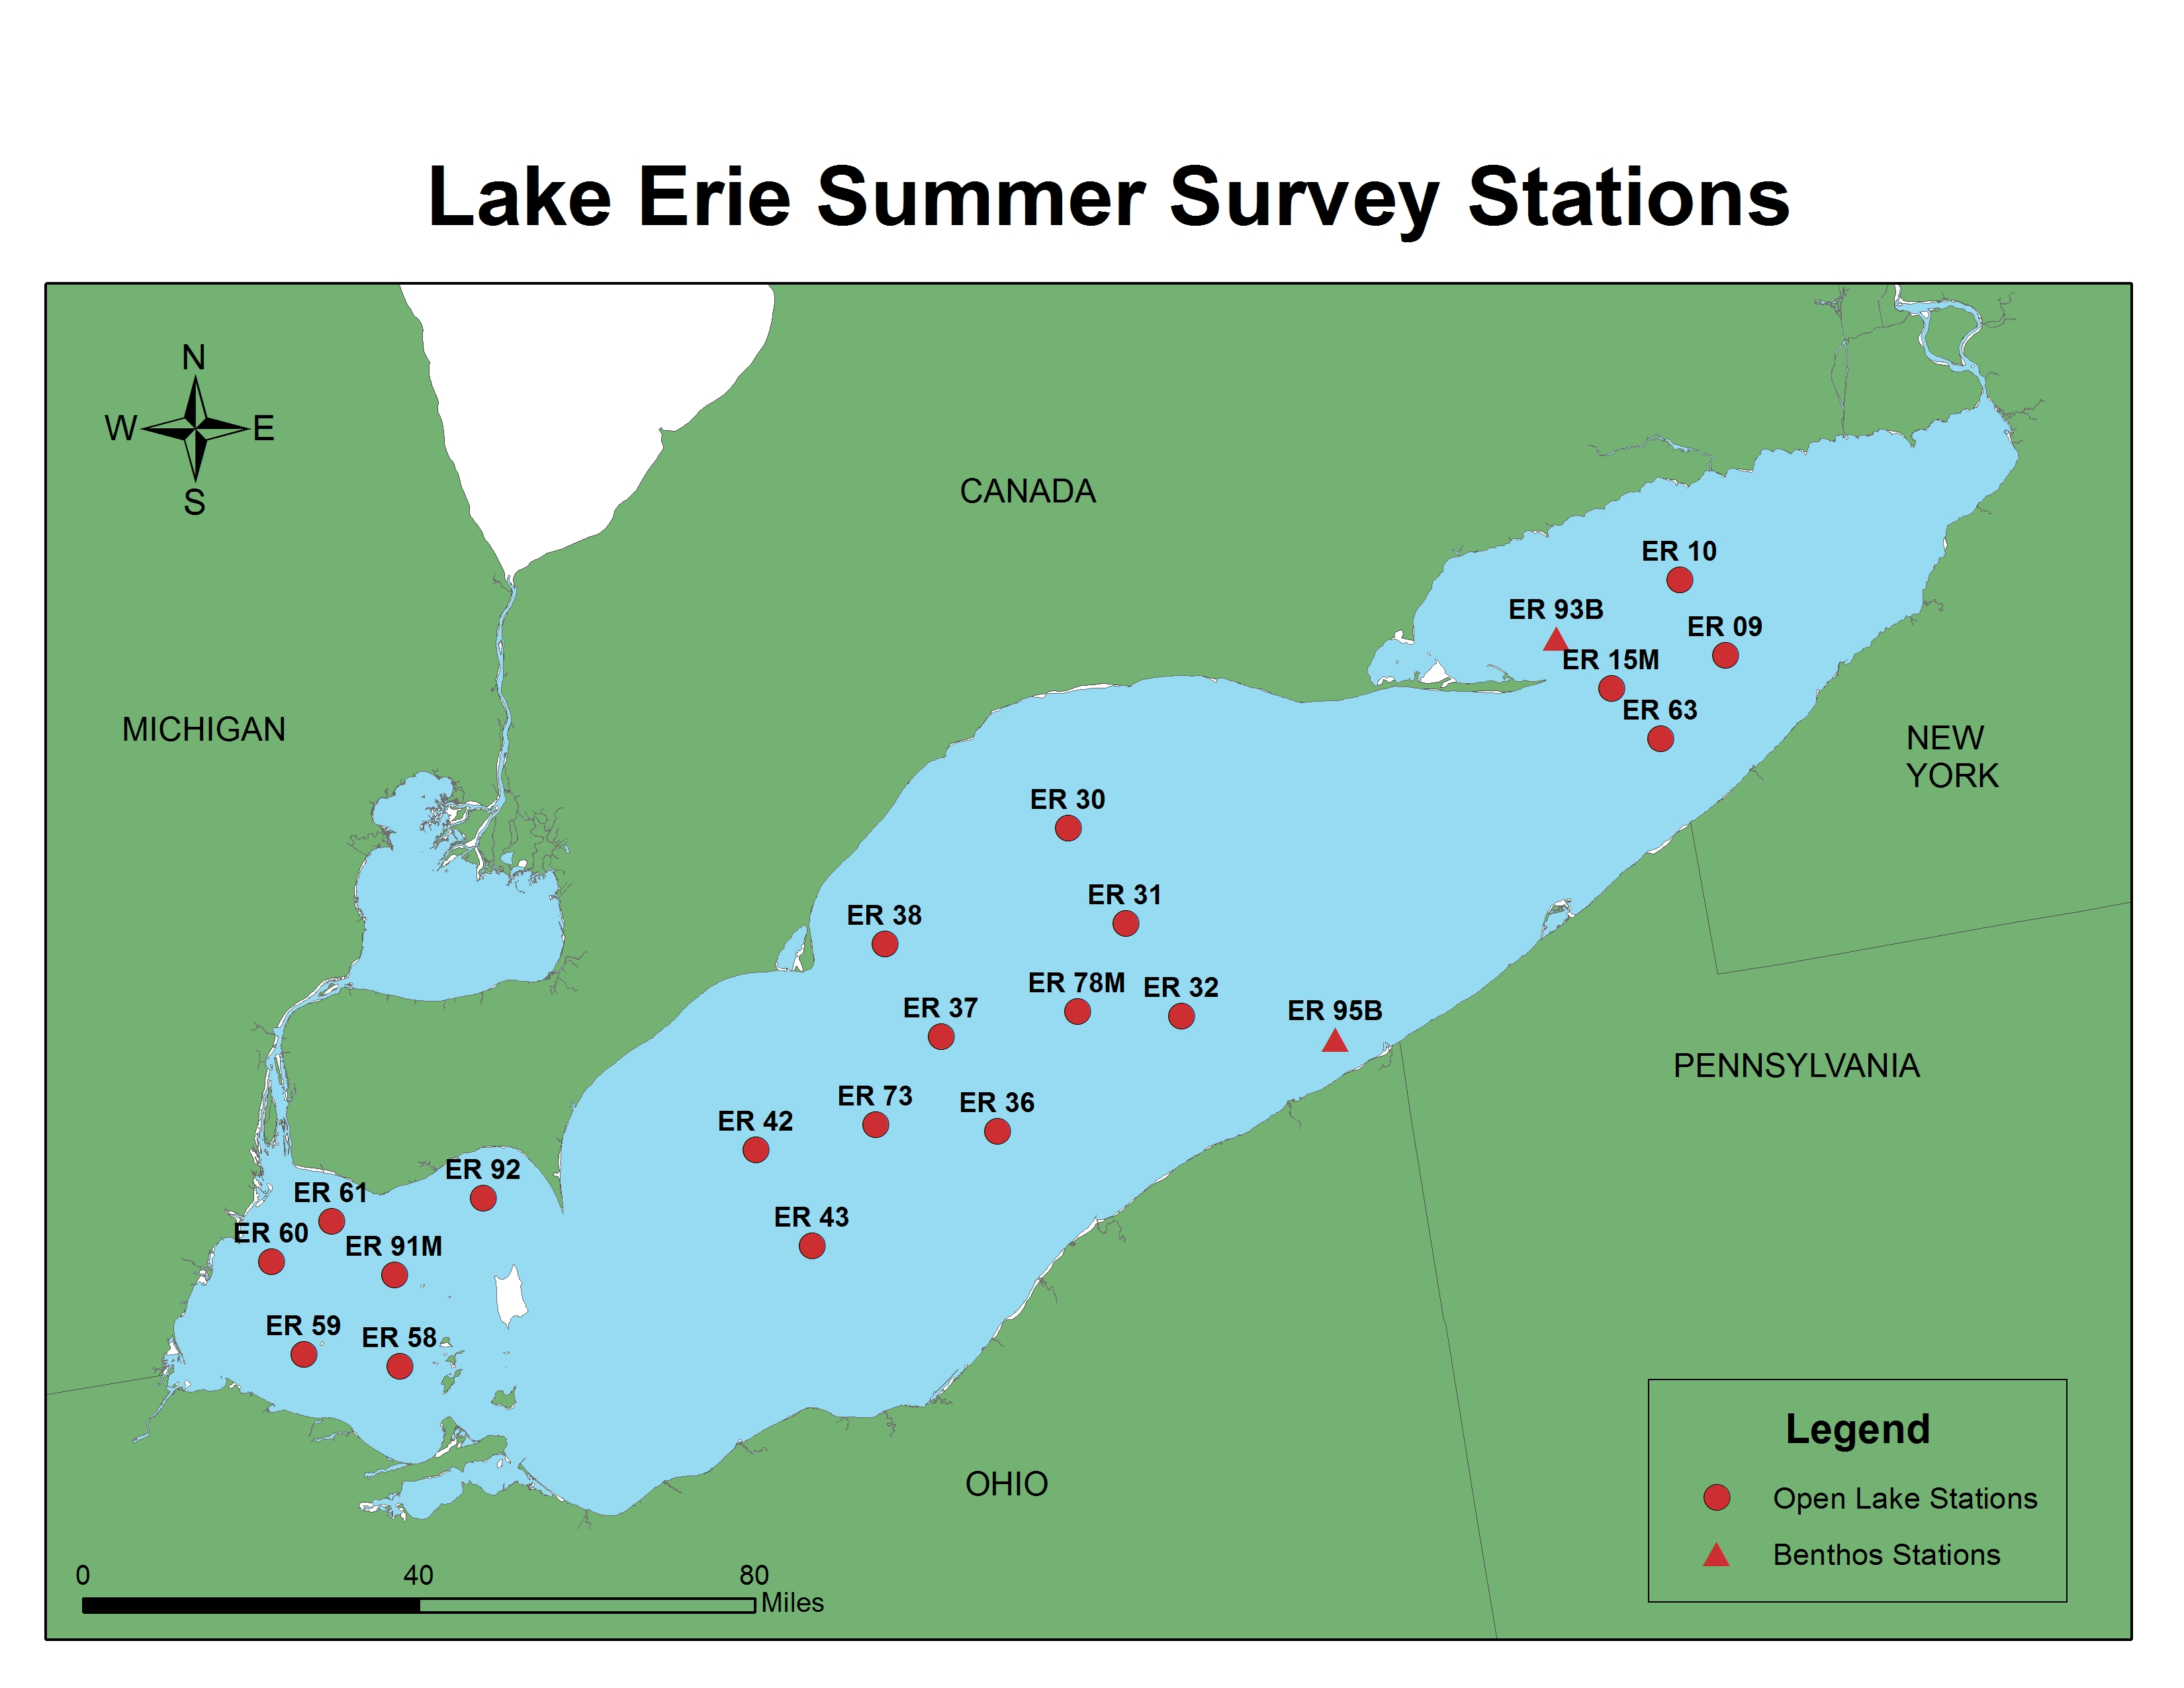

In [2]:
from IPython.display import Image
Image(filename='../../measurements/GLNPO/Erie_Summer_Survey2017.jpg') 

In [3]:
Cl = pd.read_csv('../../measurements/GLNPO/Mass Balance/Cl.csv')
Cl = Cl[Cl.QC_TYPE=='routine field sample']
Cl = Cl[~Cl.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Cl = Cl[Cl.YEAR>2002]
Cl.loc[:,'SAMPLE_DEPTH_M'] *= -1

In [4]:
eastern_basin = ['ER15M', 'ER09', 'ER63', 'ER10']
central_basin = ['ER78M', 'ER38', 'ER37', 'ER42', 'ER30', 'ER73', 'ER36', 'ER32'] #, 'ER43','ER31']
western_basin = ['ER58', 'ER59', 'ER61', 'ER60', 'ER92', 'ER91M']

In [5]:
stations = eastern_basin + central_basin + western_basin
years = range(2003,2018)
seasons = ['Spring', 'Summer']

In [6]:
Cl = Cl[Cl['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Cl = Cl[Cl['SEASON'].isin(seasons)]
Cl['VALUE_1'] = pd.to_numeric(Cl['VALUE_1'], errors='coerce')

In [7]:
# Cl[Cl.YEAR>1999].groupby(['STATION_ID','SEASON']).describe()['VALUE_1'].applymap('{:.1f}'.format)

In [36]:
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
# x = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
# y = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

# tck,u  = interpolate.splprep([x,y], s=0)
# unew = np.arange(0, 1.00, 0.1)
# out = interpolate.splev(unew, tck)

# # tck = interpolate.splrep(x, y, s=0)
# # xnew = np.arange(0, 2*np.pi, np.pi/50)
# # ynew = interpolate.splev(xnew, tck, der=0)

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


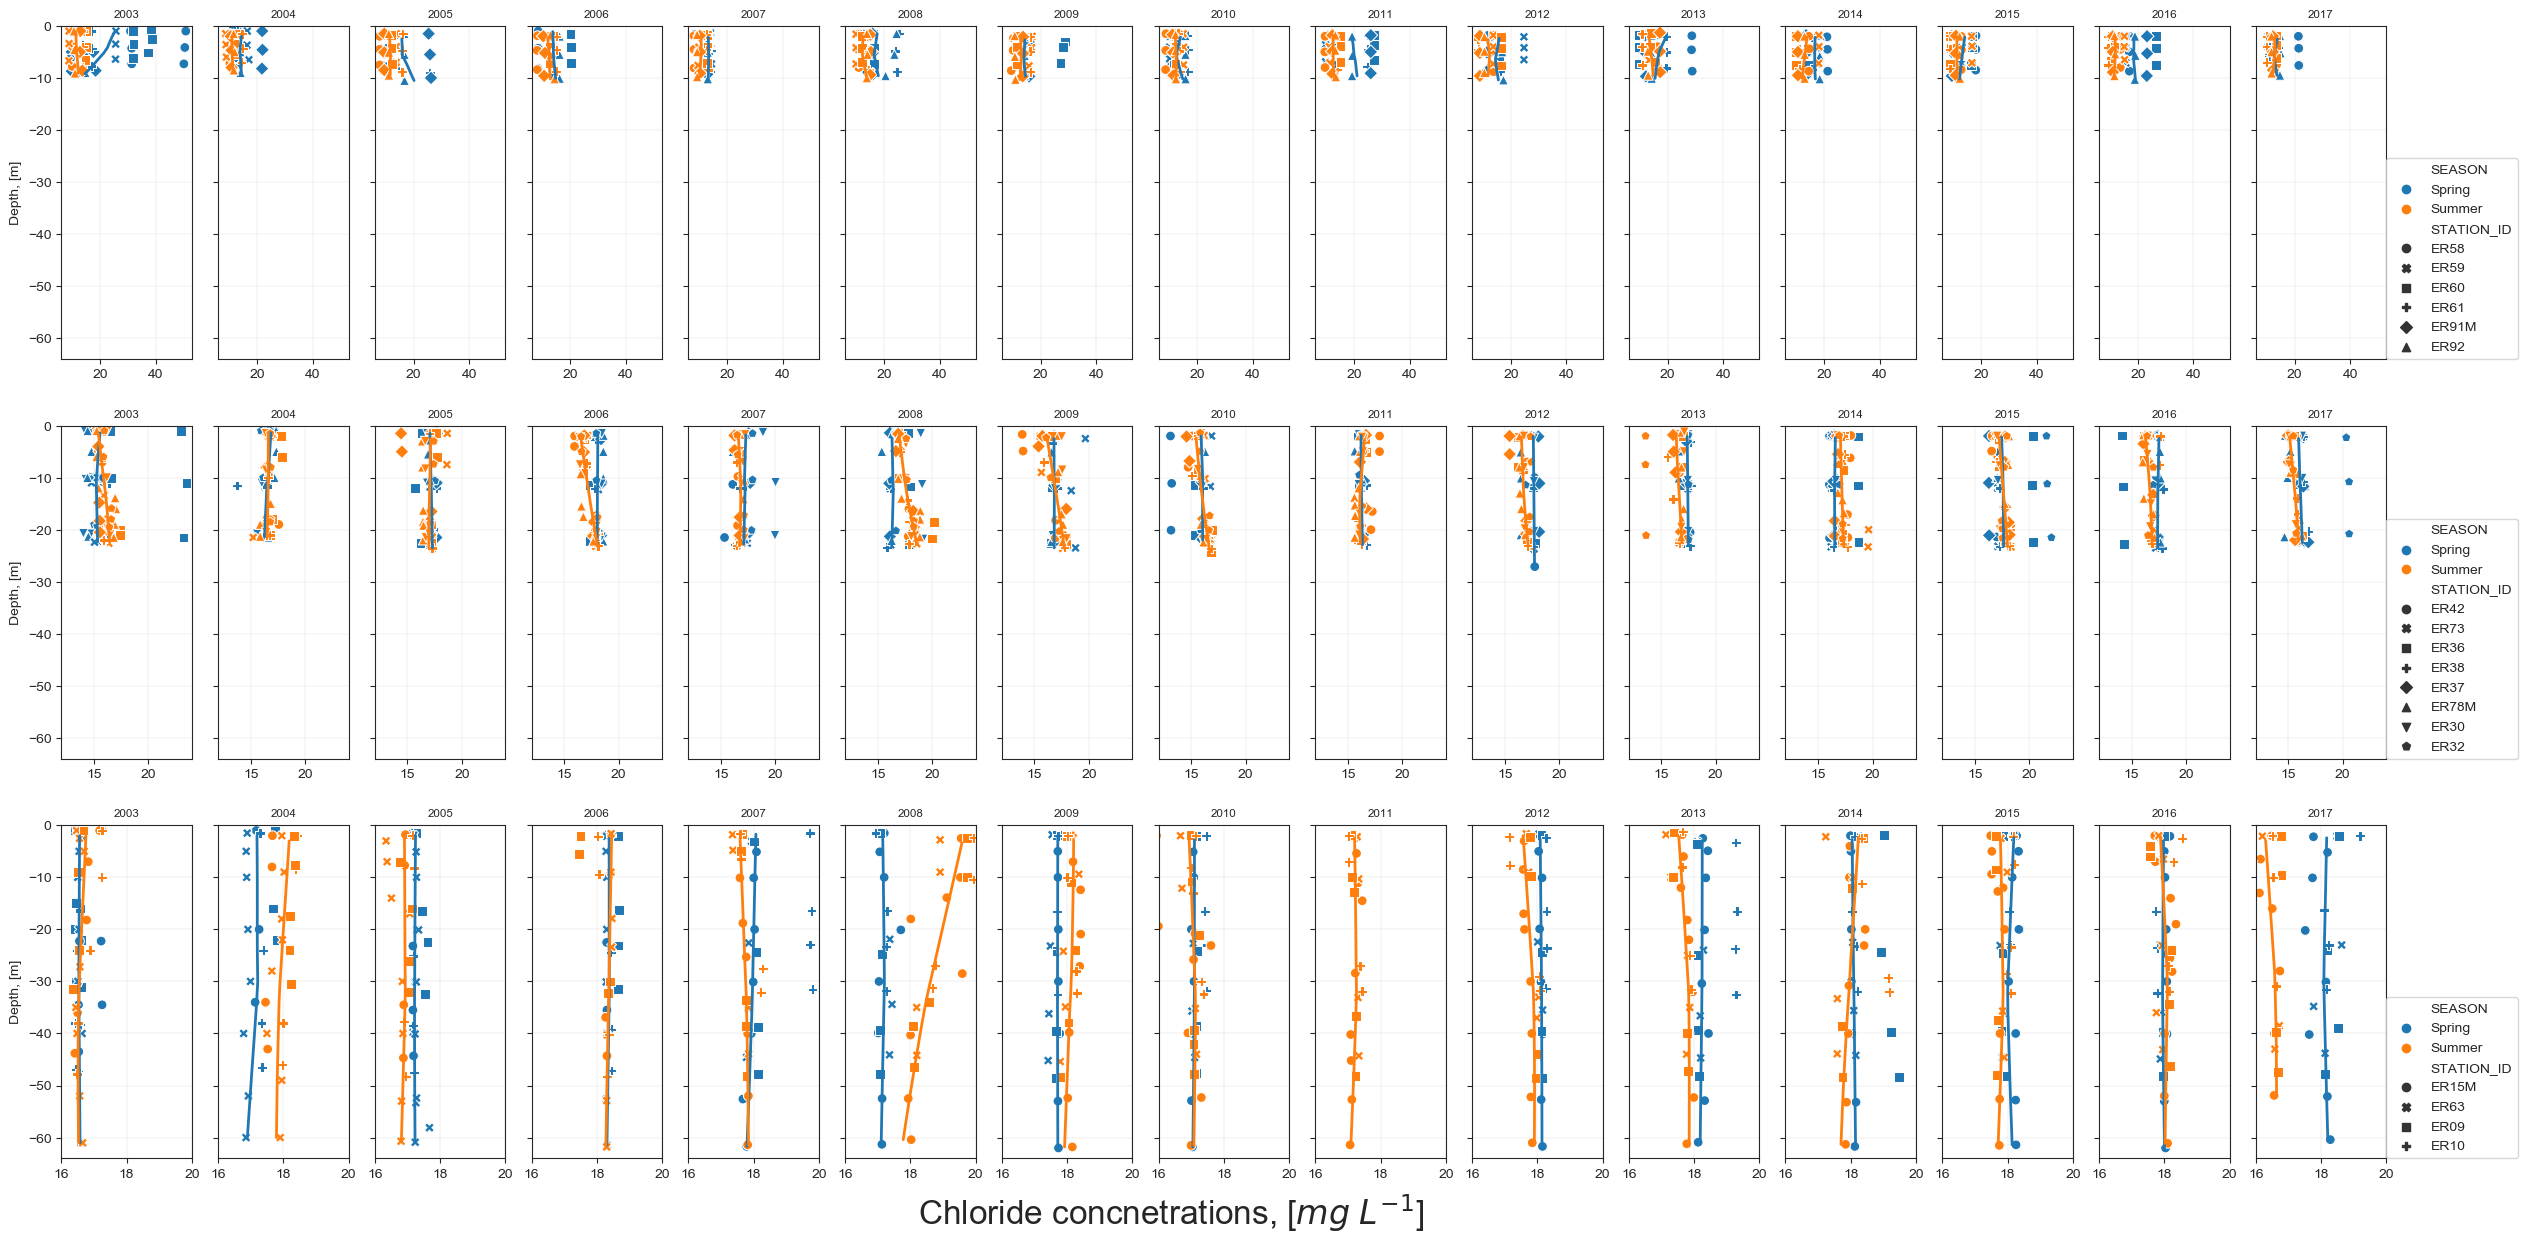

In [53]:
# %matplotlib osx
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Cl[(Cl['STATION_ID'].isin(b)) & (Cl['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            
            # lowess will return our "smoothed" data with a y value for at every x-value
            lowess = sm.nonparametric.lowess(yold, xold, frac=1)

            # unpack the lowess smoothed points to their values
            lowess_x = list(zip(*lowess))[0]
            lowess_y = list(zip(*lowess))[1]

                        
            tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
            unew = np.arange(xold.min(), xold.max(), 1)
            out = tck(unew)
            
            if s=='Spring':
                clr=sns.color_palette().as_hex()[0]
            if s=='Summer':
                clr=sns.color_palette().as_hex()[1]
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
#             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
#             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

            axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
    axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Chloride concnetrations, [$mg$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Chloride_mgL.pdf')




In [14]:
Temp = pd.read_csv('../../measurements/GLNPO/Mass Balance/Temp.csv')
Temp = Temp[Temp.QC_TYPE=='routine field sample']
Temp = Temp[~Temp.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Temp = Temp[Temp.YEAR>2002]
Temp.loc[:,'SAMPLE_DEPTH_M'] *= -1
Temp = Temp[Temp['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Temp = Temp[Temp['SEASON'].isin(seasons)]
Temp['VALUE_1'] = pd.to_numeric(Temp['VALUE_1'], errors='coerce')

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (37,38,44,45,47,48,50,51,54,55,57,58,61,62,64,65,68,69,71,72,75,76,78,79,82,83,85,86,89,90,92,93,96,97,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


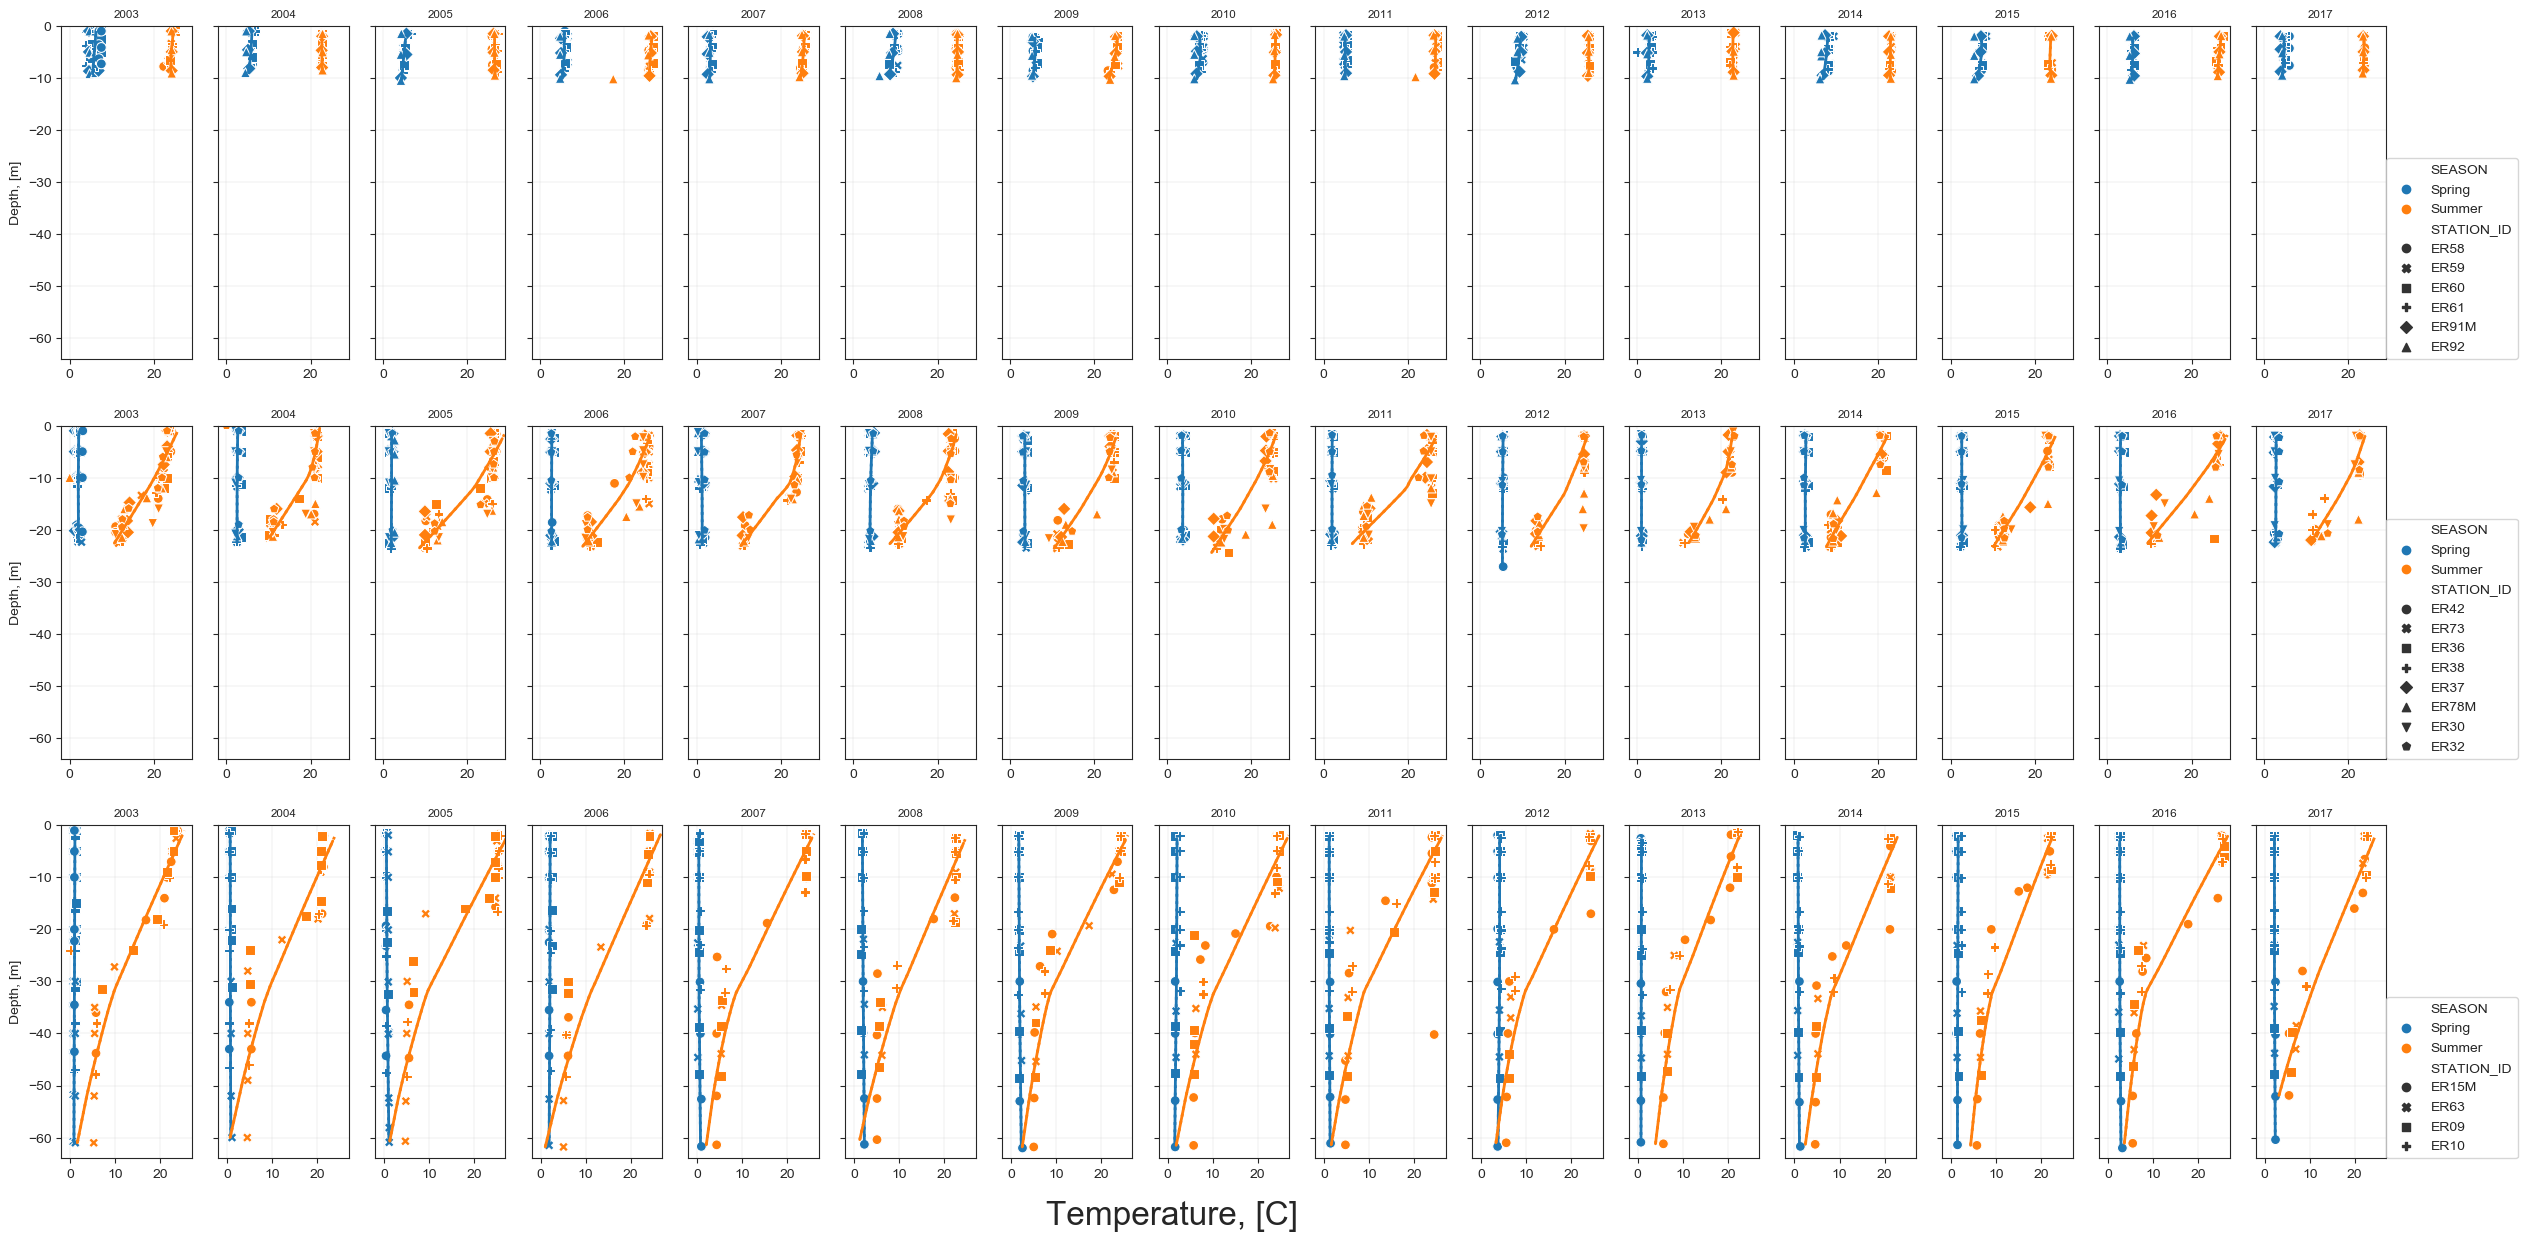

In [54]:
# %matplotlib osx
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Temp[(Temp['STATION_ID'].isin(b)) & (Temp['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

#             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
#             unew = np.arange(0, 1.00, 0.1)
#             out = interpolate.splev(unew, tck)
            
#             tck = interpolate.UnivariateSpline(xold, yold, k=5, s=10000000)
#             unew = np.arange(xold.min(), xold.max(), 1)
#             out = tck(unew)

            # lowess will return our "smoothed" data with a y value for at every x-value
            lowess = sm.nonparametric.lowess(yold, xold, frac=1)

            # unpack the lowess smoothed points to their values
            lowess_x = list(zip(*lowess))[0]
            lowess_y = list(zip(*lowess))[1]

                        
            tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
            unew = np.arange(xold.min(), xold.max(), 1)
            out = tck(unew)
            
            if s=='Spring':
                clr=sns.color_palette().as_hex()[0]
            if s=='Summer':
                clr=sns.color_palette().as_hex()[1]
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
#             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
#             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1
            axes[i][j].plot(lowess_y, lowess_x, c=clr, lw=2,zorder=1, ls=':')
            axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

axes[2][2].set_xlim(16,18)
axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
#     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
# axes[2][0].text(8.5,-0.2, 'Chloride concnetrations, [$mg$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Chloride_mgL_16_20.pdf')



axes[2][0].text(8.5,-0.2, 'Temperature, [C]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# plt.draw()
f.savefig('Mass Balance/GLENDA/All Stations/Temperature_C.pdf')

In [56]:
Alk = pd.read_csv('../../measurements/GLNPO/Mass Balance/Alk.csv')
Alk = Alk[Alk.QC_TYPE=='routine field sample']
Alk = Alk[~Alk.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Alk = Alk[Alk.YEAR>2002]
Alk.loc[:,'SAMPLE_DEPTH_M'] *= -1
Alk = Alk[Alk['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Alk = Alk[Alk['SEASON'].isin(seasons)]
Alk['VALUE_1'] = pd.to_numeric(Alk['VALUE_1'], errors='coerce')

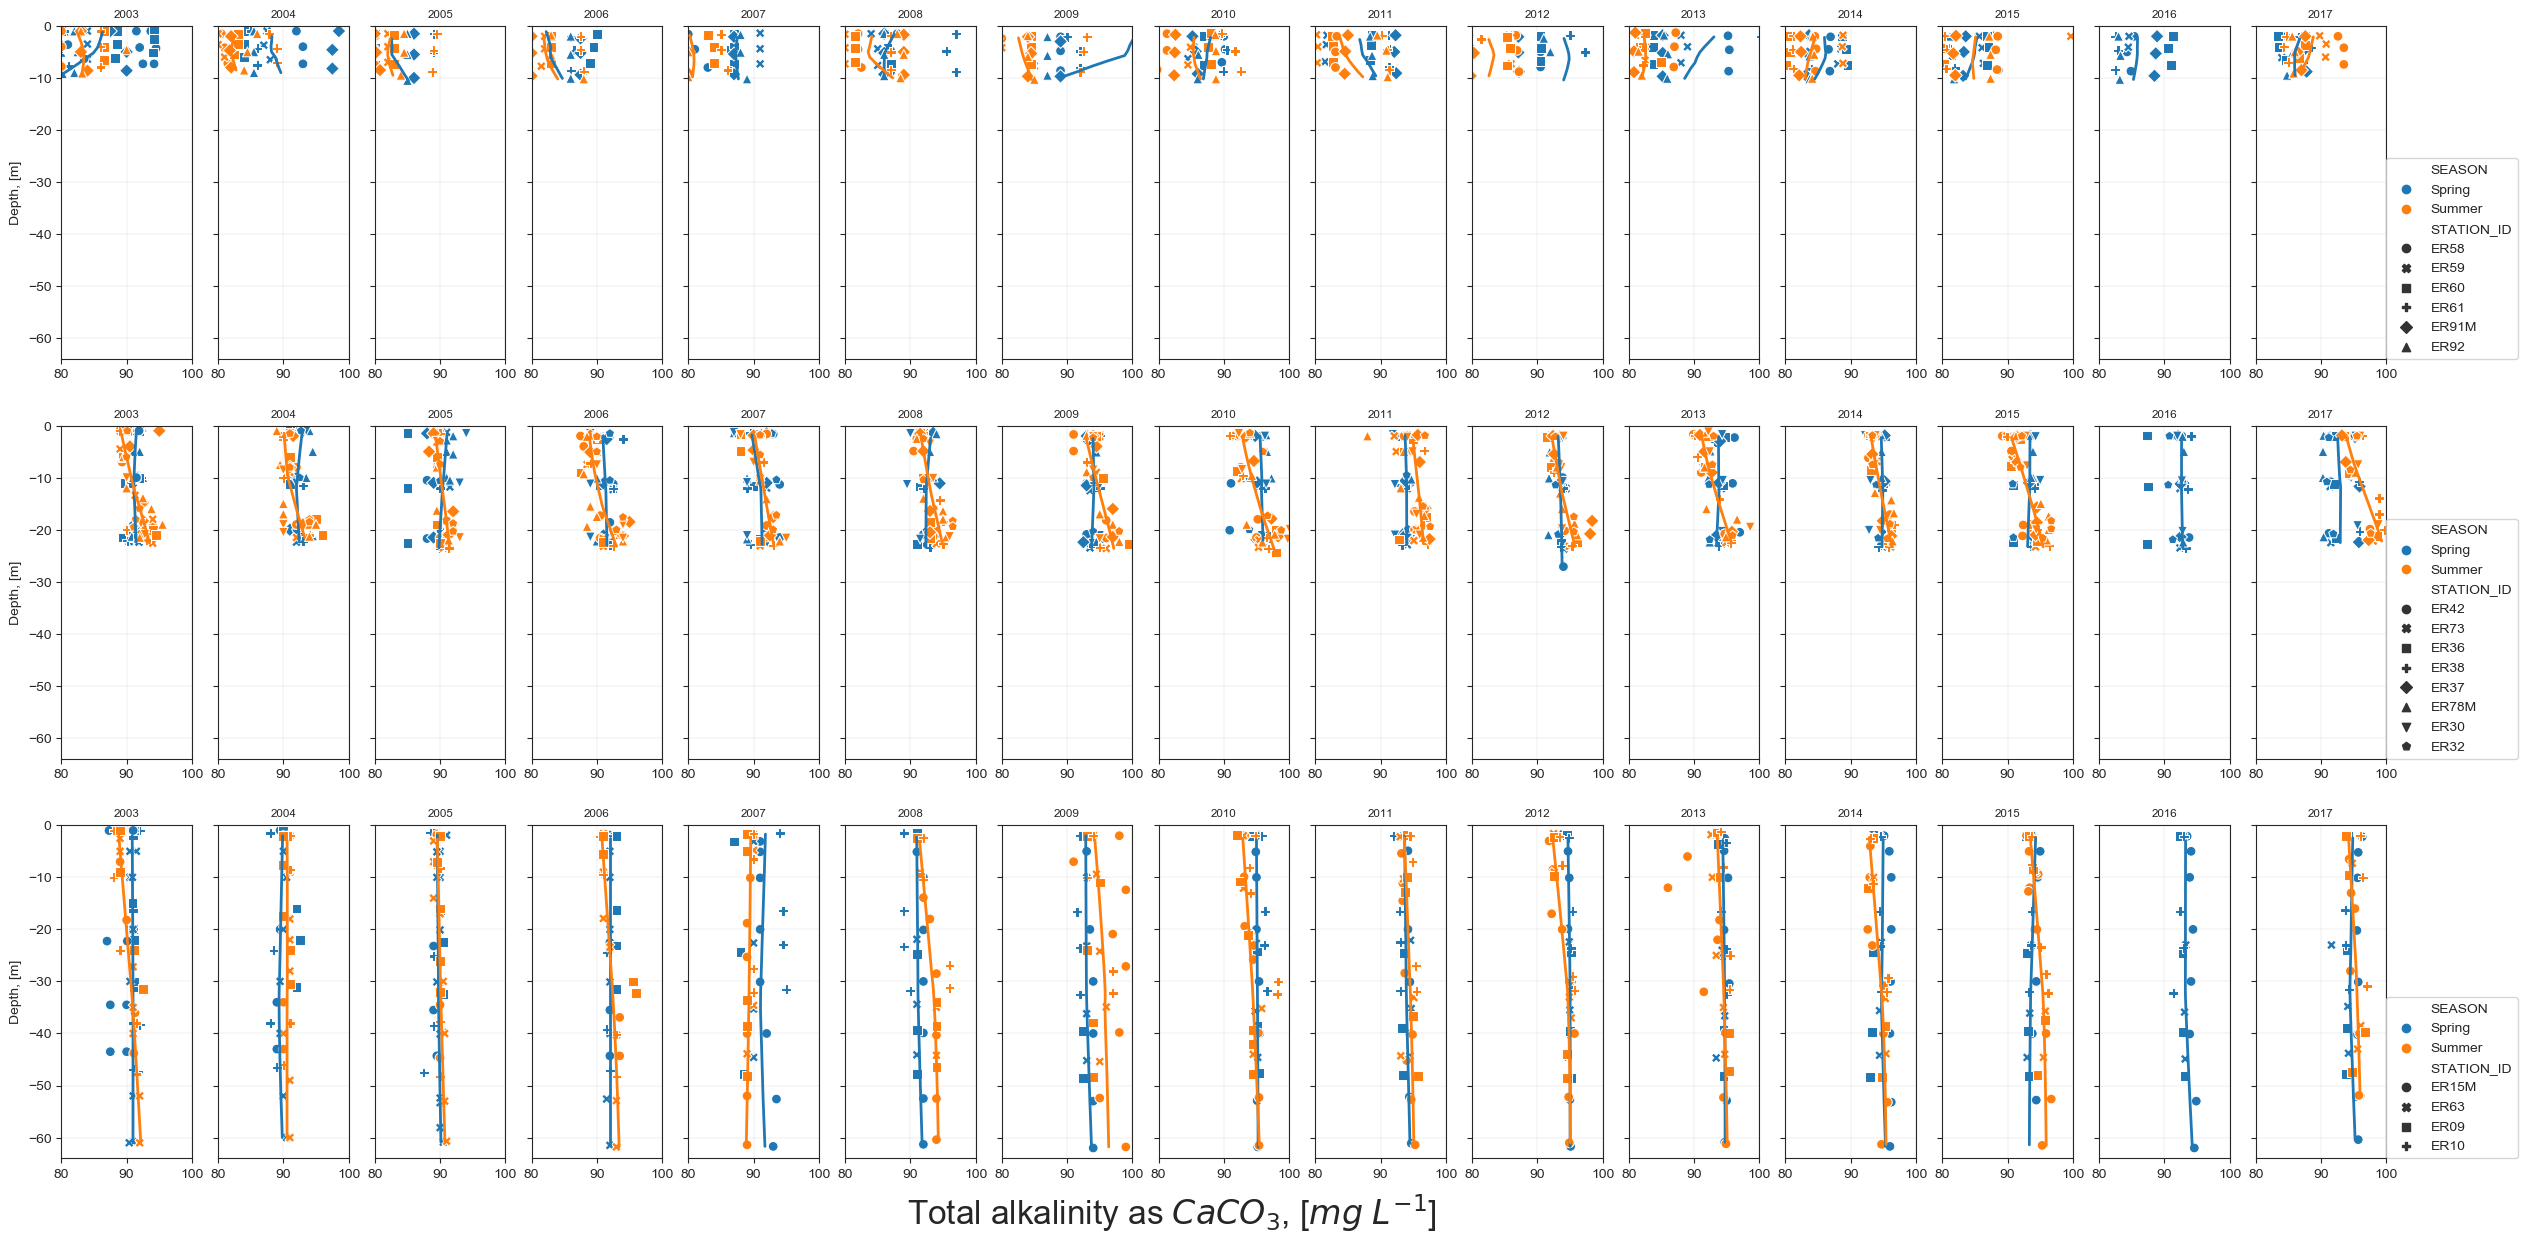

In [62]:
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Alk[(Alk['STATION_ID'].isin(b)) & (Alk['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
    axes[0][i].set_xlim(80,100)
    axes[1][i].set_xlim(80,100)
    axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Total alkalinity as $CaCO_3$, [$mg$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Tot_alkalinity_no_scales_80_100.pdf')




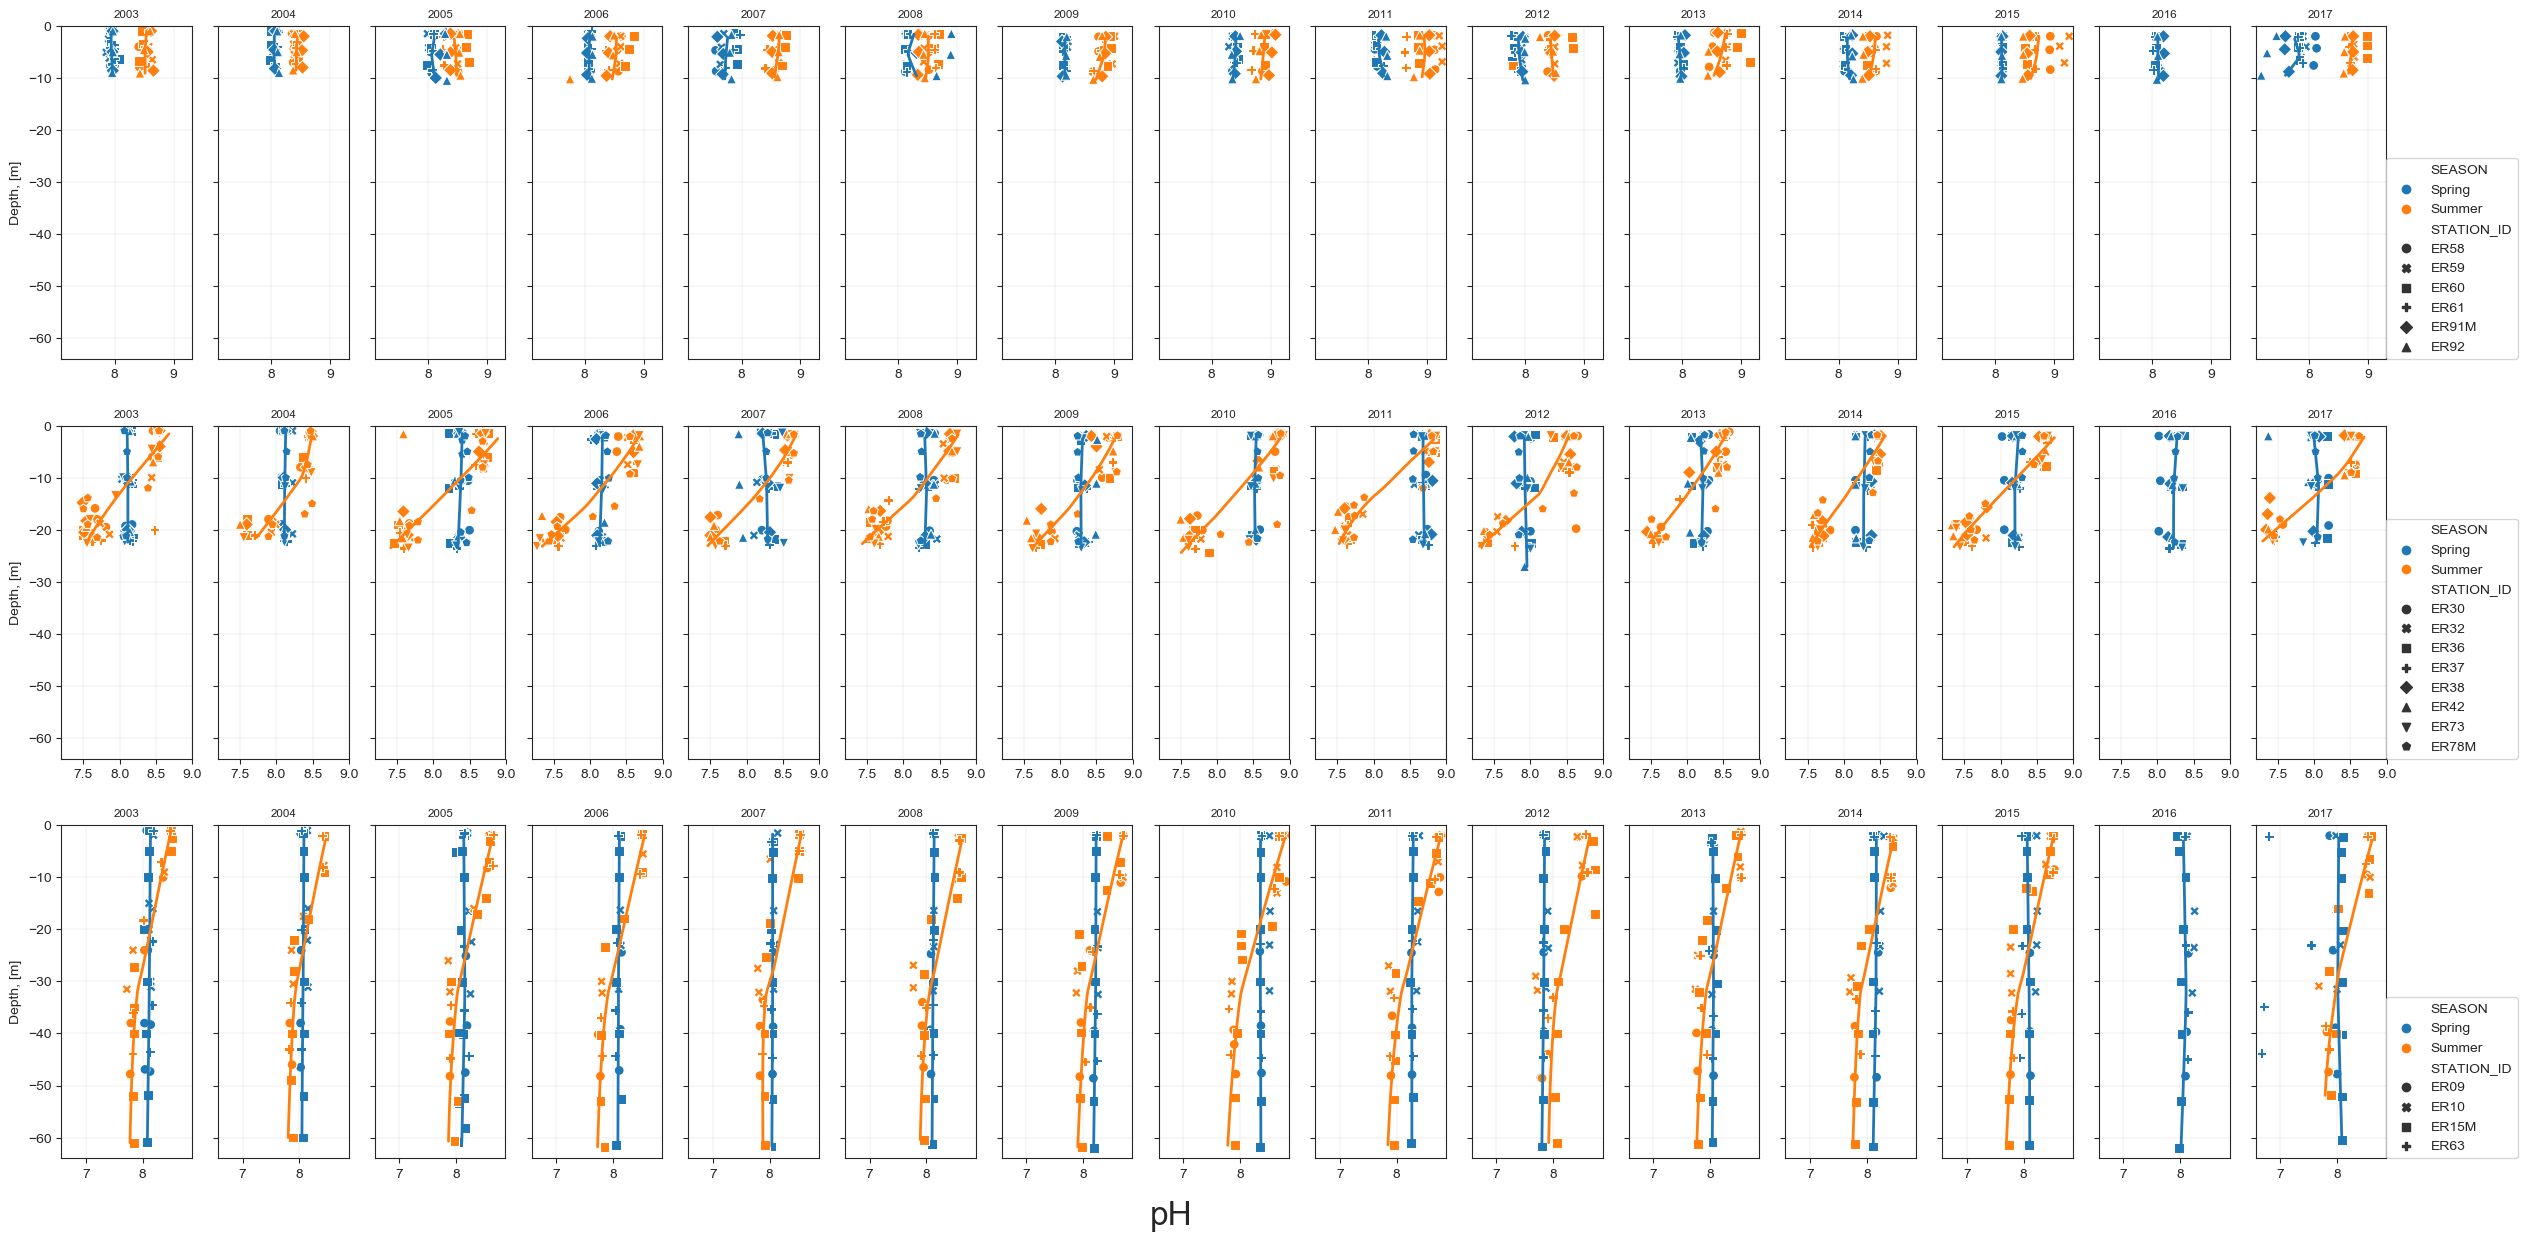

In [66]:
pH = pd.read_csv('../../measurements/GLNPO/Mass Balance/pH.csv')
pH = pH[pH.QC_TYPE=='routine field sample']
pH = pH[~pH.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
pH = pH[pH.YEAR>2002]
pH.loc[:,'SAMPLE_DEPTH_M'] *= -1
pH = pH[pH['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
pH = pH[pH['SEASON'].isin(seasons)]
pH['VALUE_1'] = pd.to_numeric(pH['VALUE_1'], errors='coerce')
# pH = pH[pH['VALUE_1']>50]
pH = pH.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = pH[(pH['STATION_ID'].isin(b)) & (pH['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
#             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=clr)
#             axes[i][j].set_xlim(0,30)
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((min(low),max(high)))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(80,100)
#     axes[1][i].set_xlim(80,100)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'pH', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/pH.pdf')

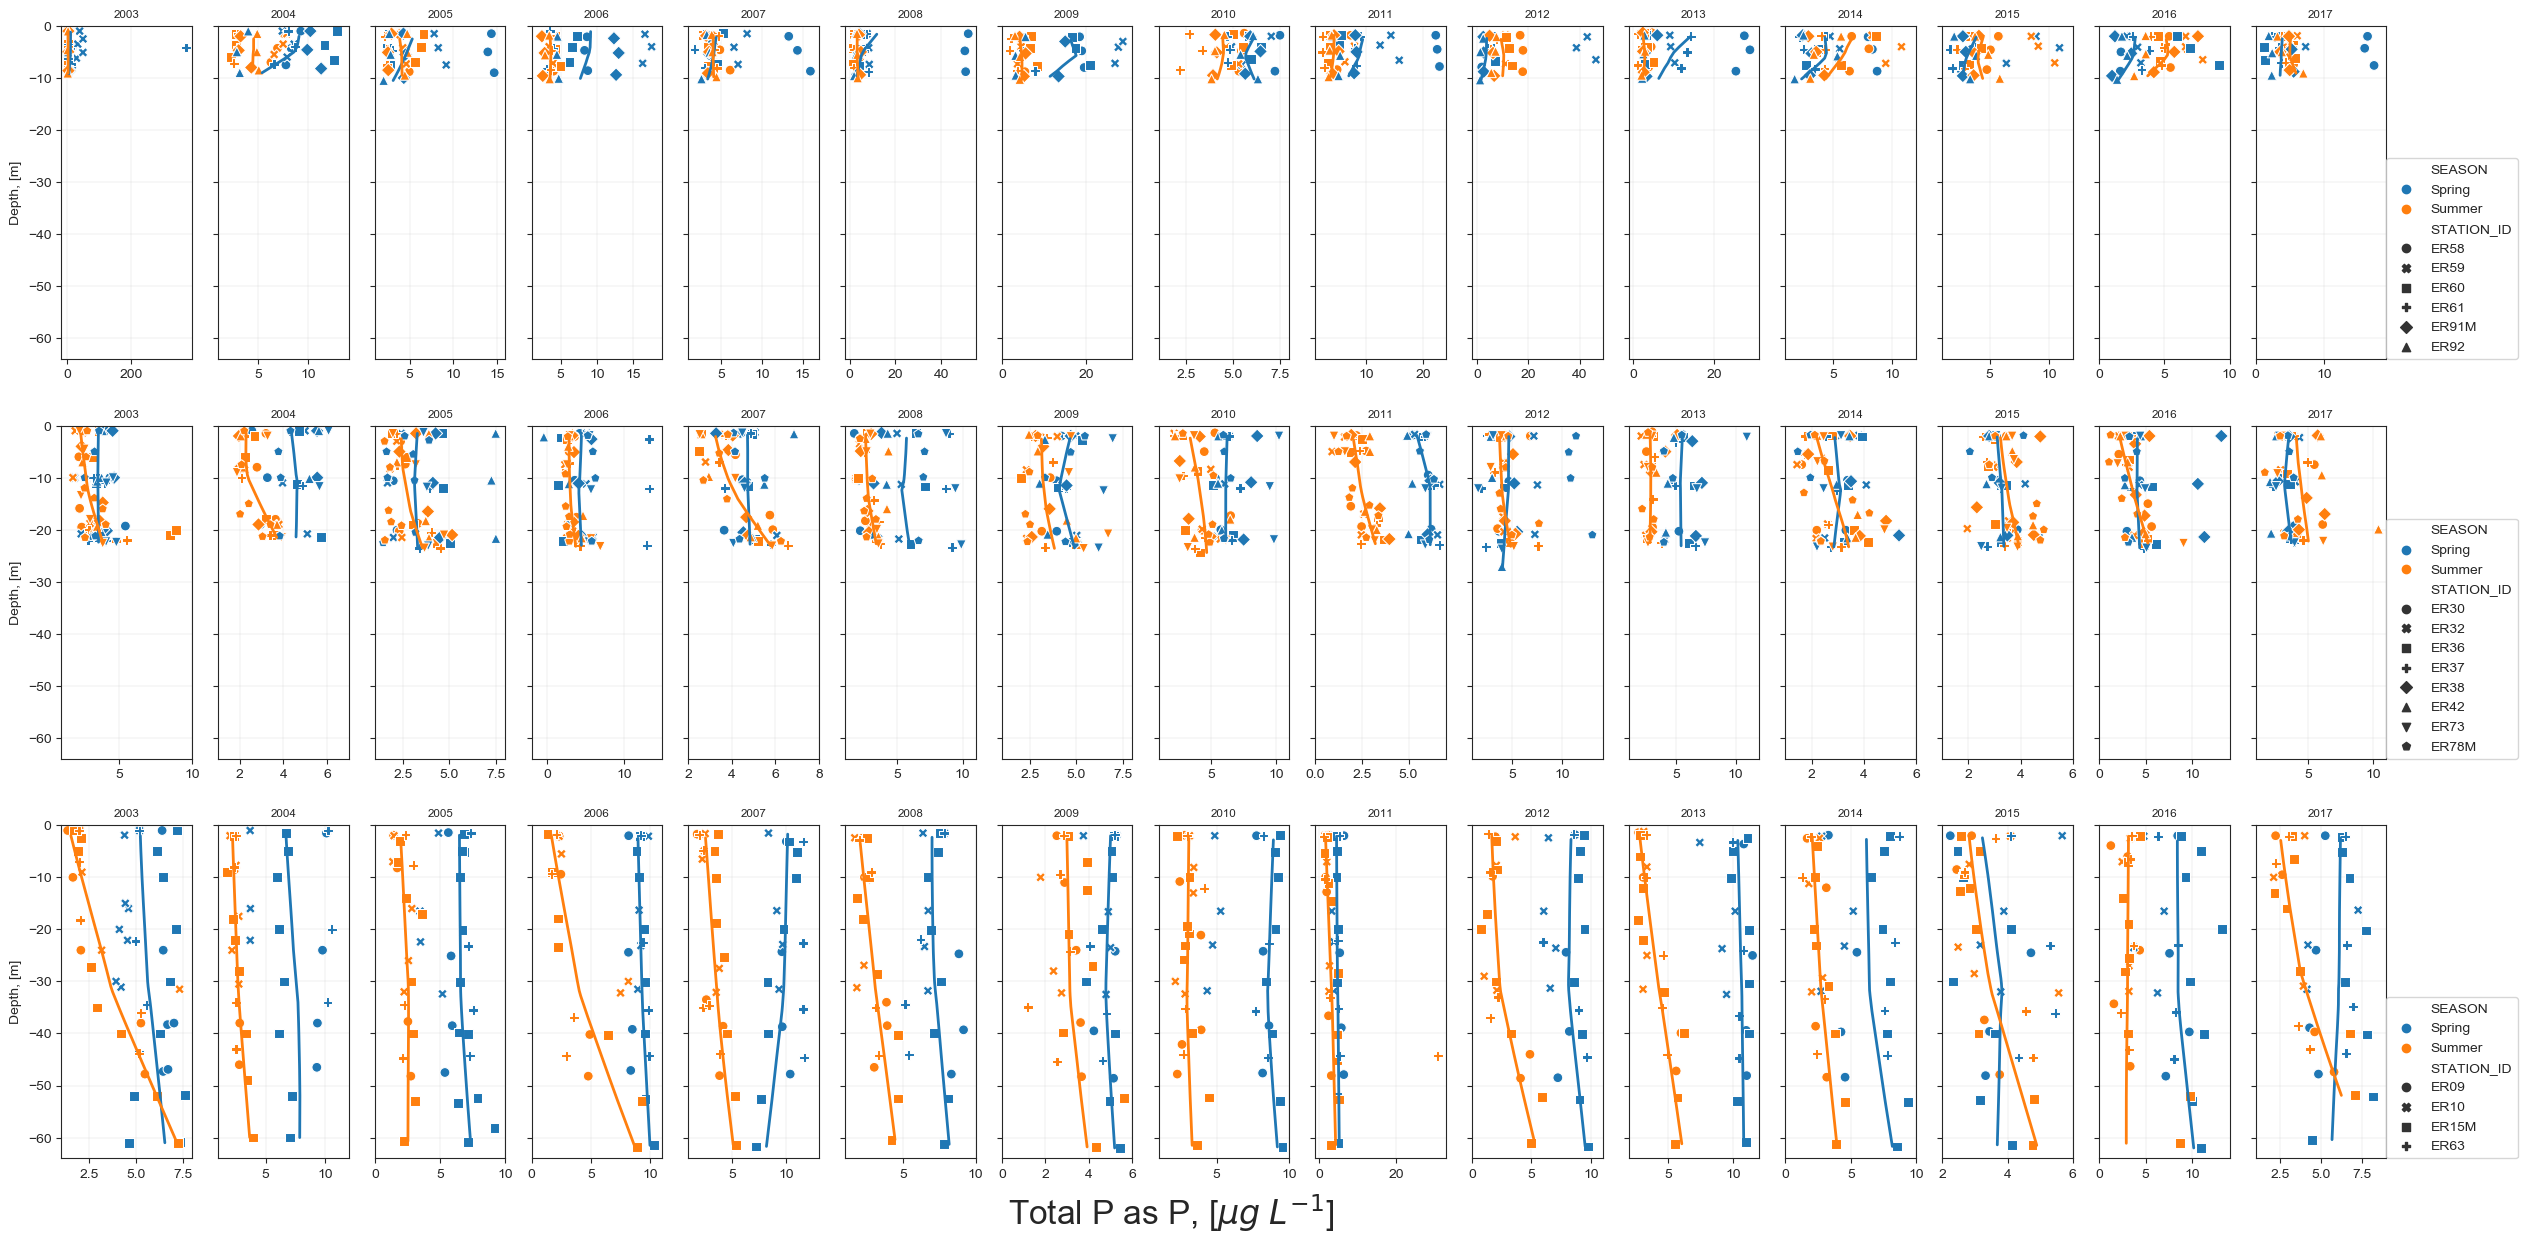

In [70]:
TOTP = pd.read_csv('../../measurements/GLNPO/Mass Balance/TOTP.csv')
TOTP = TOTP[TOTP.QC_TYPE=='routine field sample']
TOTP = TOTP[~TOTP.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
TOTP = TOTP[TOTP.YEAR>2002]
TOTP.loc[:,'SAMPLE_DEPTH_M'] *= -1
TOTP = TOTP[TOTP['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
TOTP = TOTP[TOTP['SEASON'].isin(seasons)]
TOTP['VALUE_1'] = pd.to_numeric(TOTP['VALUE_1'], errors='coerce')
# TOTP = TOTP[TOTP['VALUE_1']>50]
TOTP = TOTP.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = TOTP[(TOTP['STATION_ID'].isin(b)) & (TOTP['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((np.floor(min(low)),np.ceil(max(high))))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,20)
#     axes[1][i].set_xlim(0,13)
#     axes[2][i].set_xlim(0,13)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')

axes[2][0].text(8.5,-0.2, 'Total P as P, [$\mu g$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/TOTP_ugL_no_scales.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


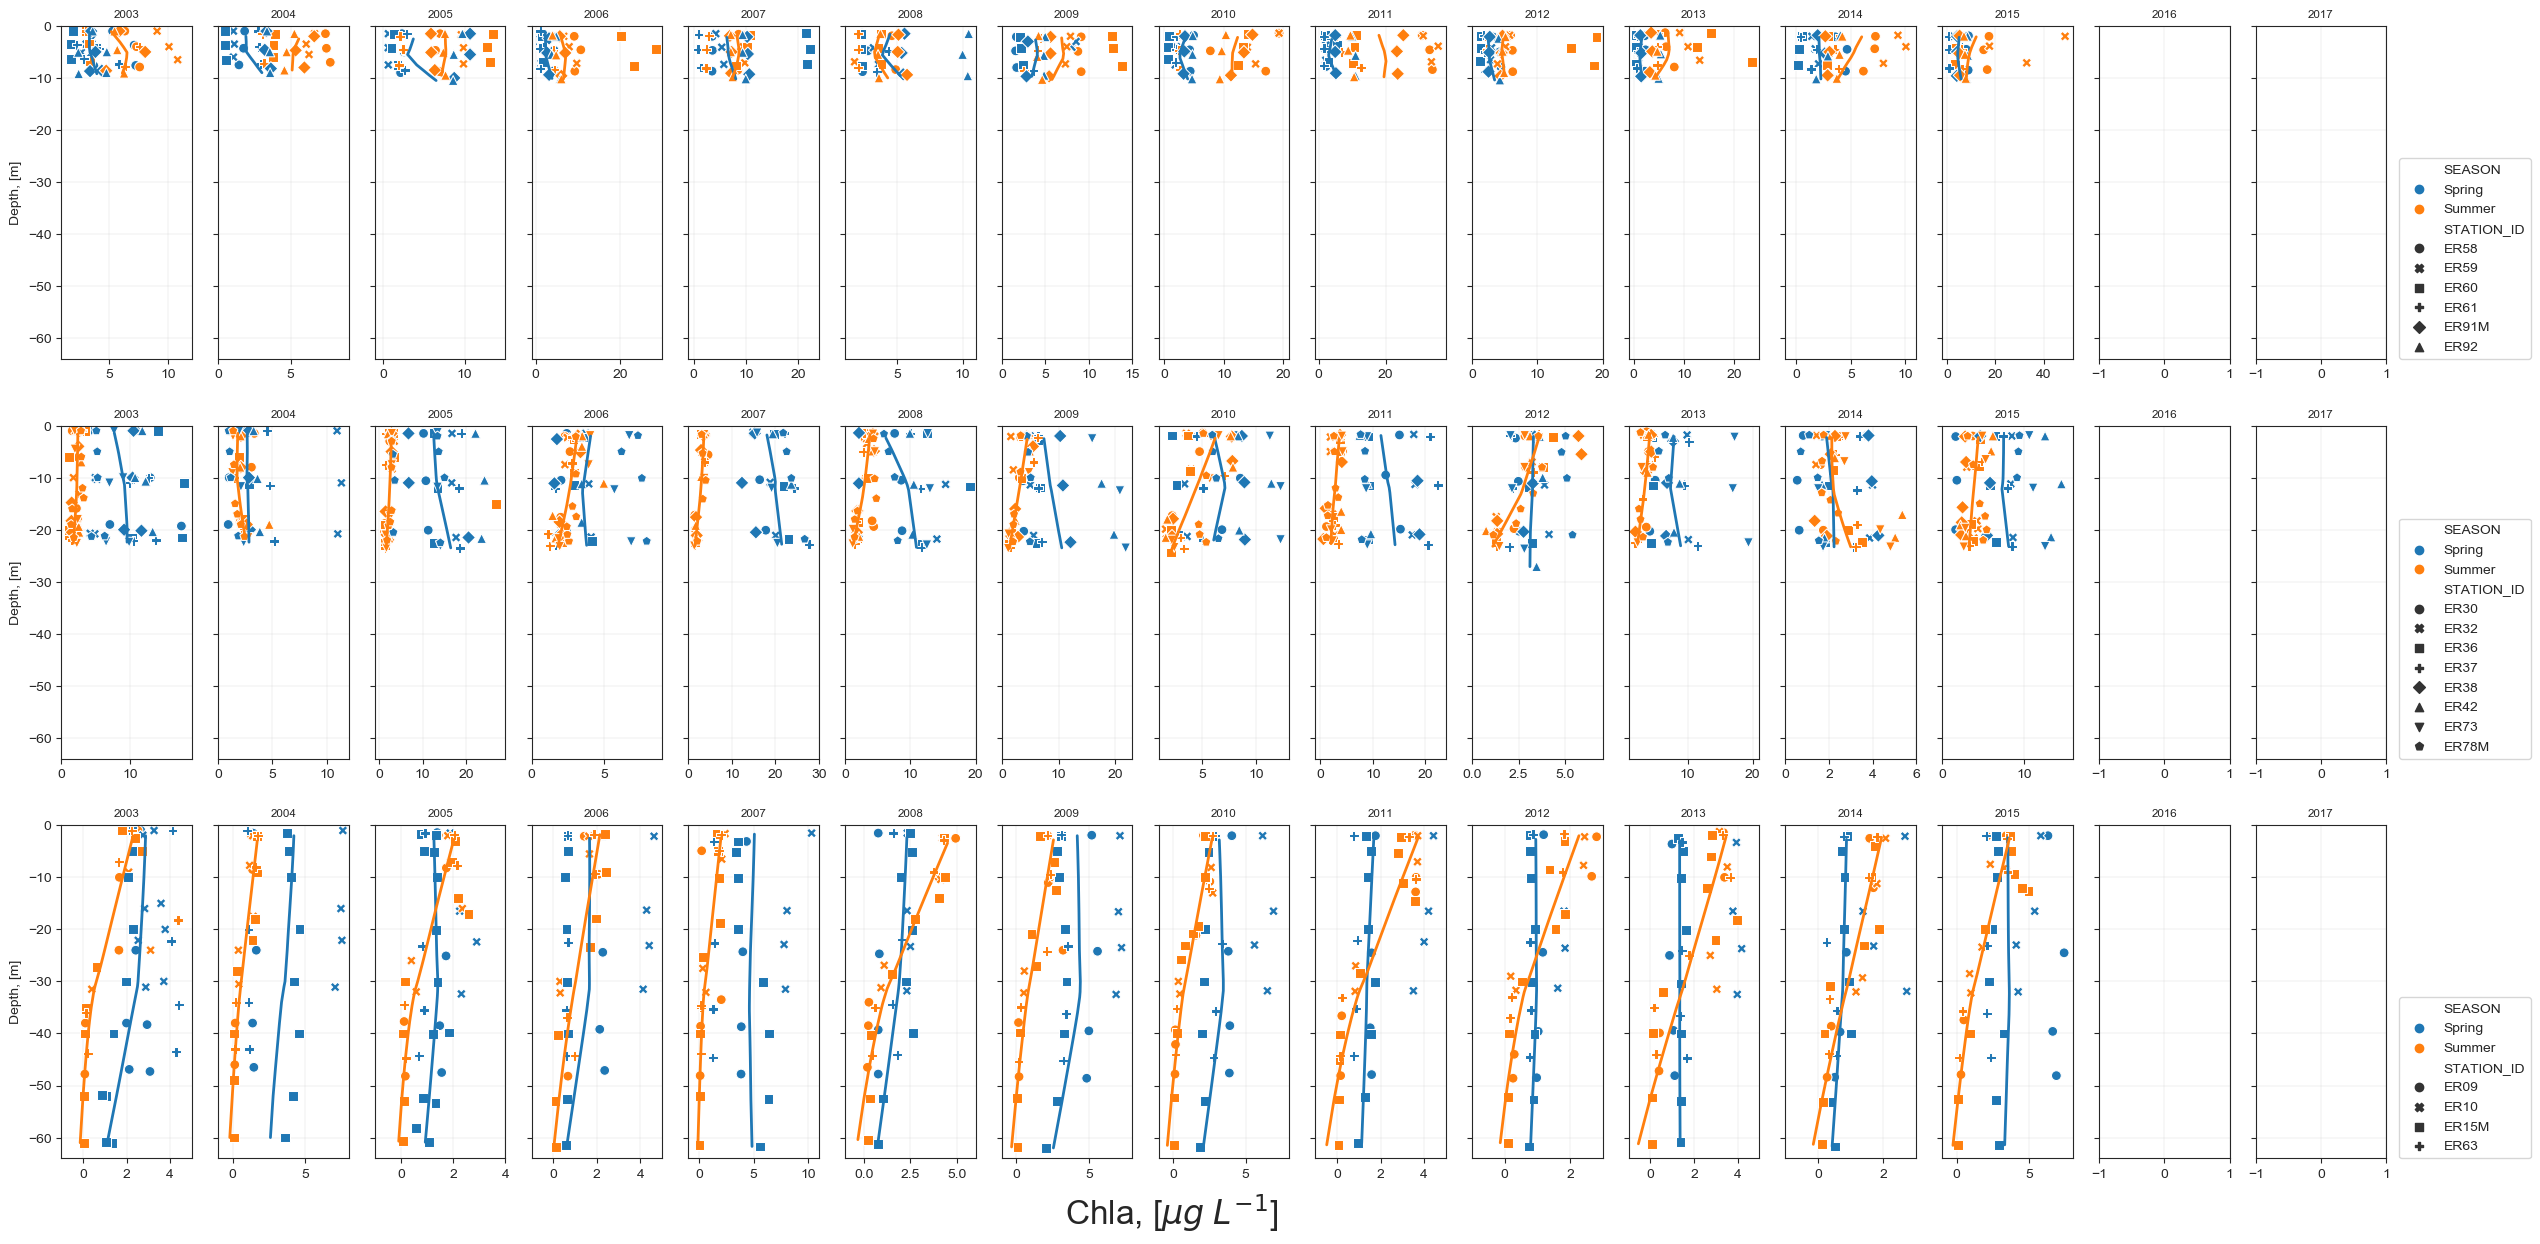

In [73]:
Chla = pd.read_csv('../../measurements/GLNPO/Mass Balance/Chla.csv')
Chla = Chla[Chla.QC_TYPE=='routine field sample']
Chla = Chla[~Chla.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Chla = Chla[Chla.YEAR>2002]
Chla.loc[:,'SAMPLE_DEPTH_M'] *= -1
Chla = Chla[Chla['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Chla = Chla[Chla['SEASON'].isin(seasons)]
Chla['VALUE_1'] = pd.to_numeric(Chla['VALUE_1'], errors='coerce')
# Chla = Chla[Chla['VALUE_1']>50]
Chla = Chla.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Chla[(Chla['STATION_ID'].isin(b)) & (Chla['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][12].legend(loc=(3.5,0))
axes[1][12].legend(loc=(3.5,0))
axes[2][12].legend(loc=(3.5,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((np.floor(min(low)),np.ceil(max(high))))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,20)
#     axes[1][i].set_xlim(0,13)
#     axes[2][i].set_xlim(0,13)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')


axes[2][0].text(8.5,-0.2, 'Chla, [$\mu g$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/Chla_ugL_no_scale.pdf')

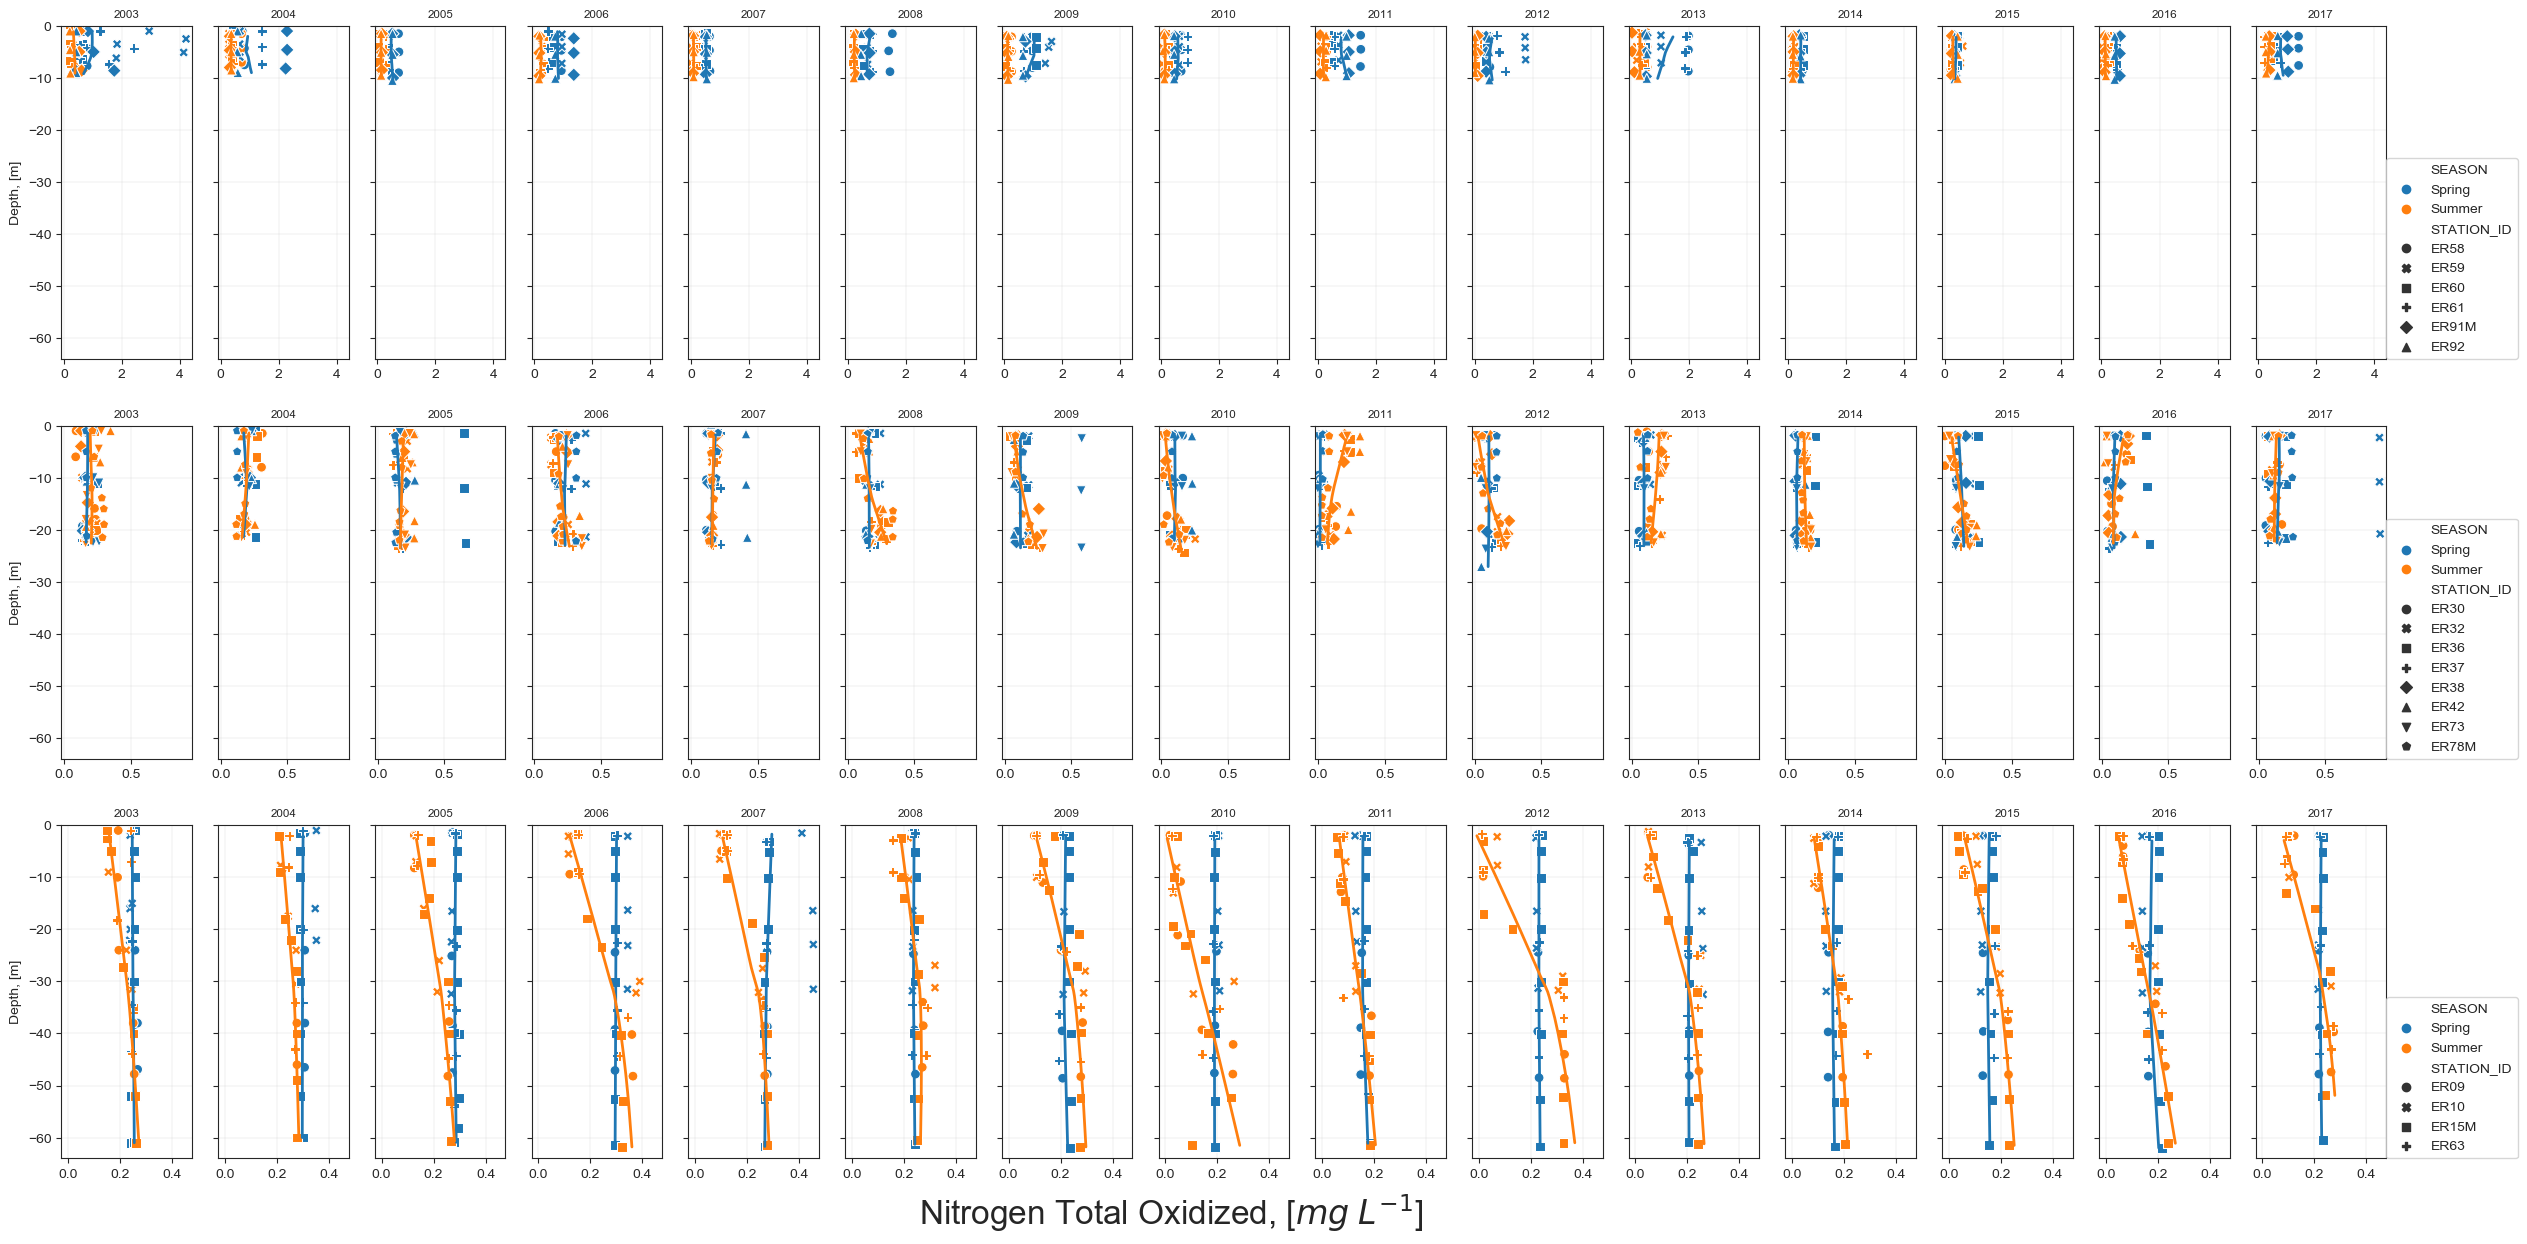

In [76]:
Ntot_oxidized = pd.read_csv('../../measurements/GLNPO/Mass Balance/Ntot_oxidized.csv')
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized.QC_TYPE=='routine field sample']
Ntot_oxidized = Ntot_oxidized[~Ntot_oxidized.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized.YEAR>2002]
Ntot_oxidized.loc[:,'SAMPLE_DEPTH_M'] *= -1
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['SEASON'].isin(seasons)]
Ntot_oxidized['VALUE_1'] = pd.to_numeric(Ntot_oxidized['VALUE_1'], errors='coerce')
# Ntot_oxidized = Ntot_oxidized[Ntot_oxidized['VALUE_1']>50]
Ntot_oxidized = Ntot_oxidized.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Ntot_oxidized[(Ntot_oxidized['STATION_ID'].isin(b)) & (Ntot_oxidized['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((min(low),max(high)))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,20)
#     axes[1][i].set_xlim(0,13)
#     axes[2][i].set_xlim(0,13)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')

axes[2][0].text(8.5,-0.2, 'Nitrogen Total Oxidized, [$m g$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Ntot_oxidized_mgL.pdf')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

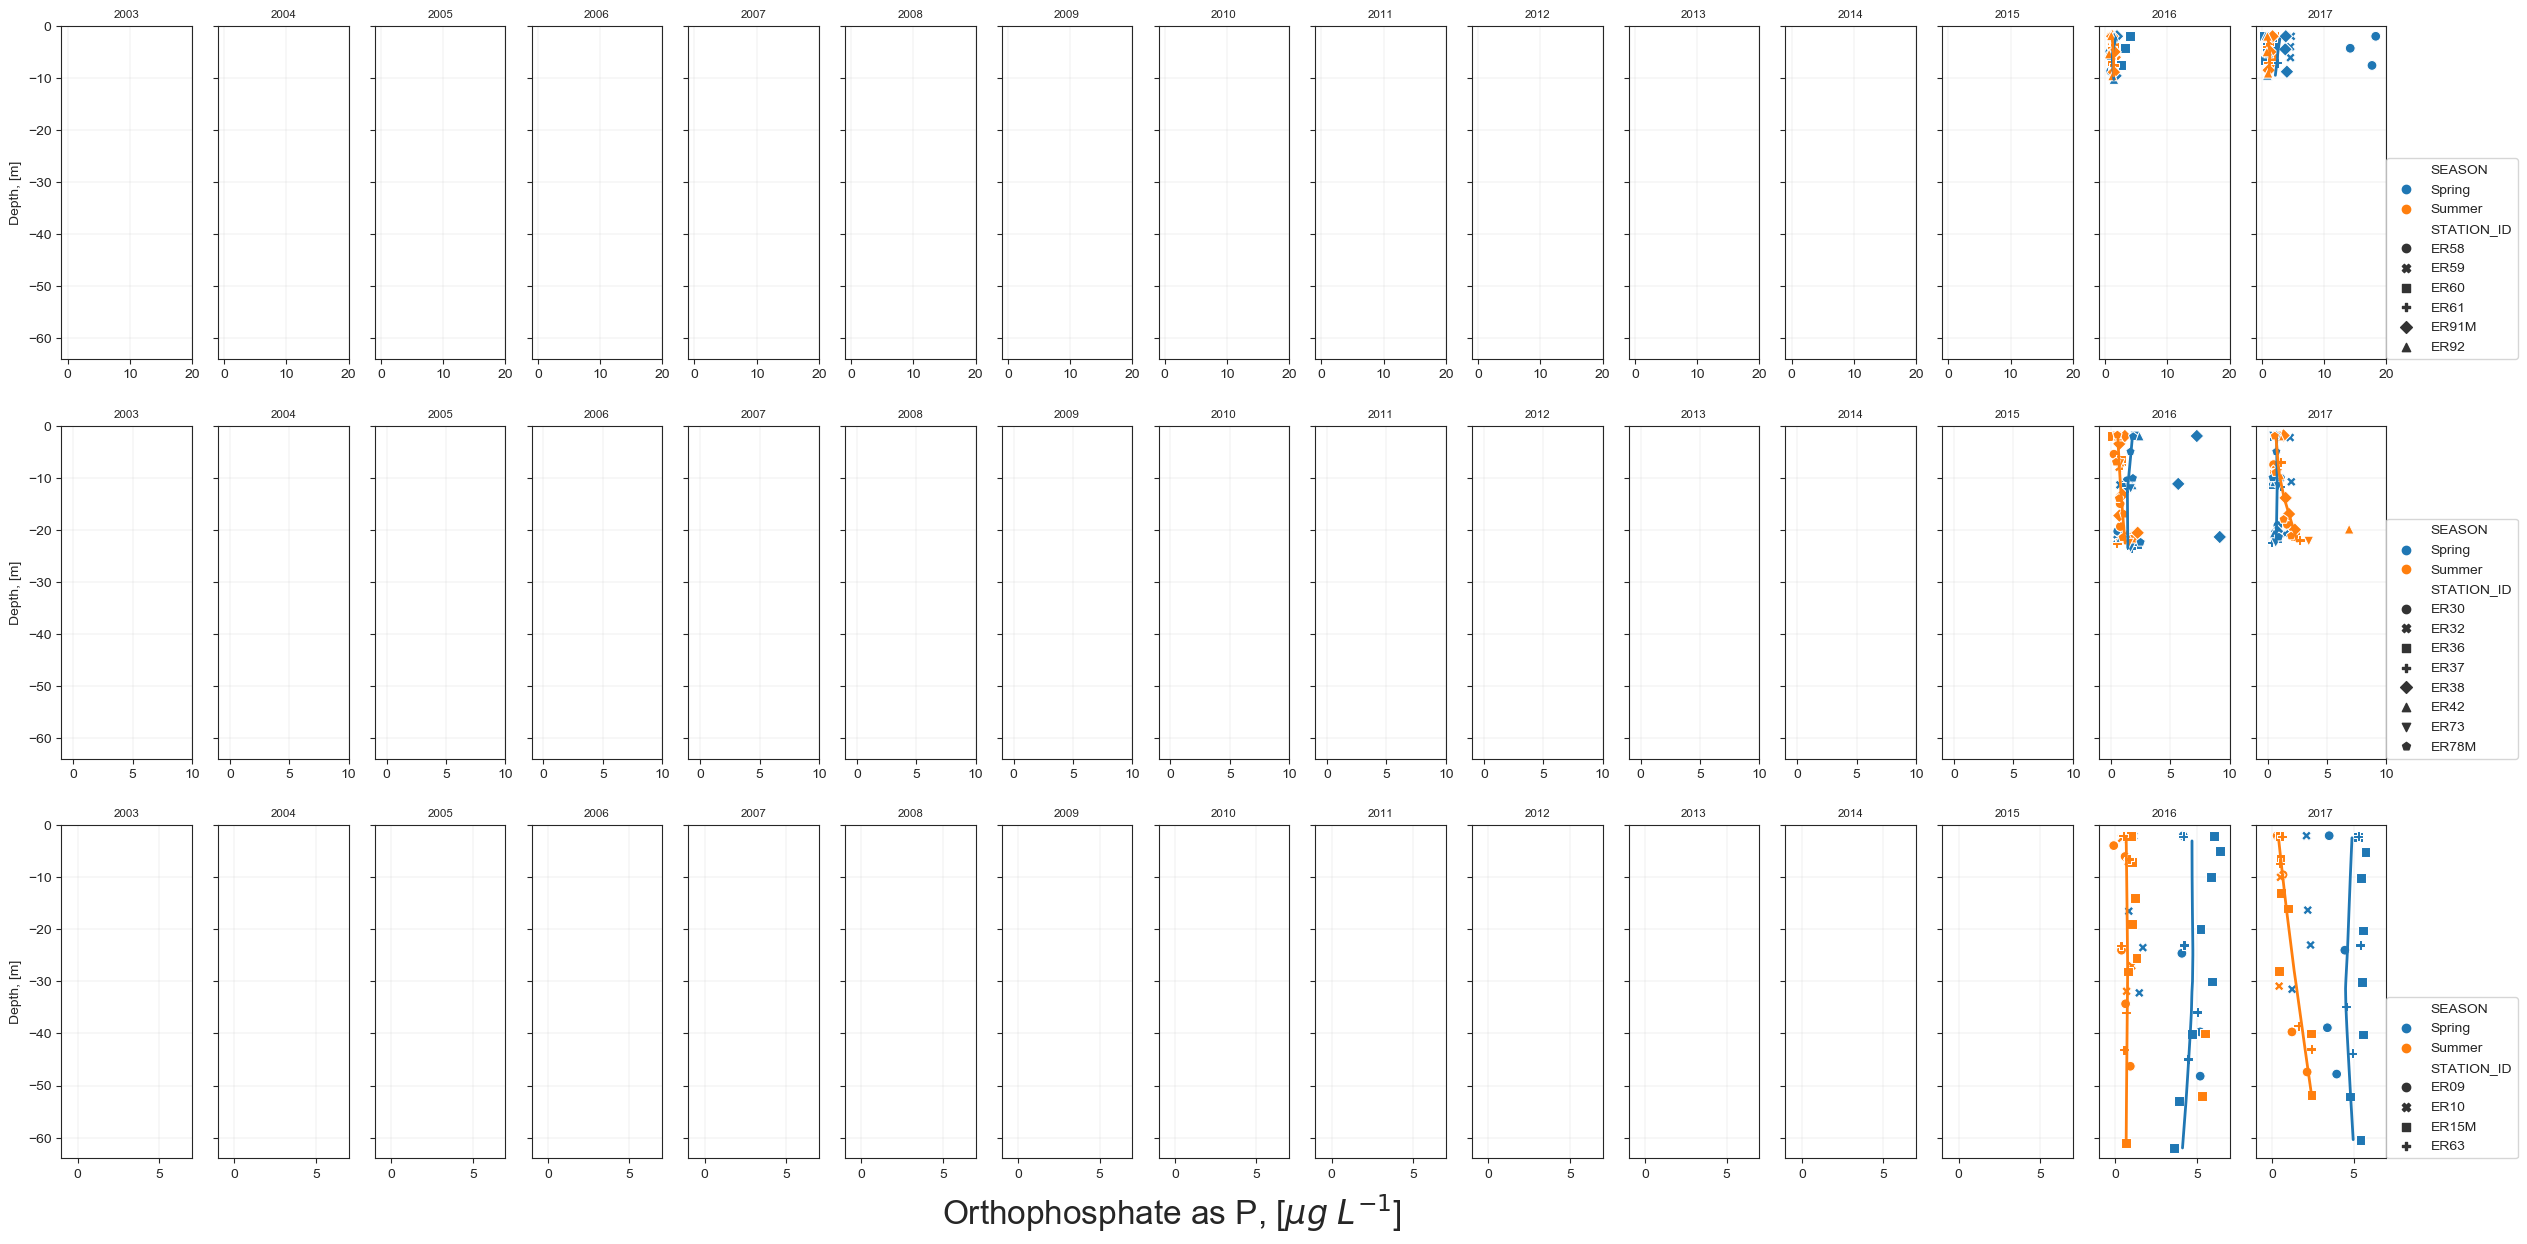

In [78]:
orthoP = pd.read_csv('../../measurements/GLNPO/Mass Balance/orthoP.csv')
orthoP = orthoP[orthoP.QC_TYPE=='routine field sample']
orthoP = orthoP[~orthoP.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
orthoP = orthoP[orthoP.YEAR>2002]
orthoP.loc[:,'SAMPLE_DEPTH_M'] *= -1
orthoP = orthoP[orthoP['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
orthoP = orthoP[orthoP['SEASON'].isin(seasons)]
orthoP['VALUE_1'] = pd.to_numeric(orthoP['VALUE_1'], errors='coerce')
# orthoP = orthoP[orthoP['VALUE_1']>50]
orthoP = orthoP.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = orthoP[(orthoP['STATION_ID'].isin(b)) & (orthoP['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,20)
#     axes[1][i].set_xlim(0,13)
#     axes[2][i].set_xlim(0,13)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')

axes[2][0].text(8.5,-0.2, 'Orthophosphate as P, [$\mu g$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/orthoP_ugL.pdf')

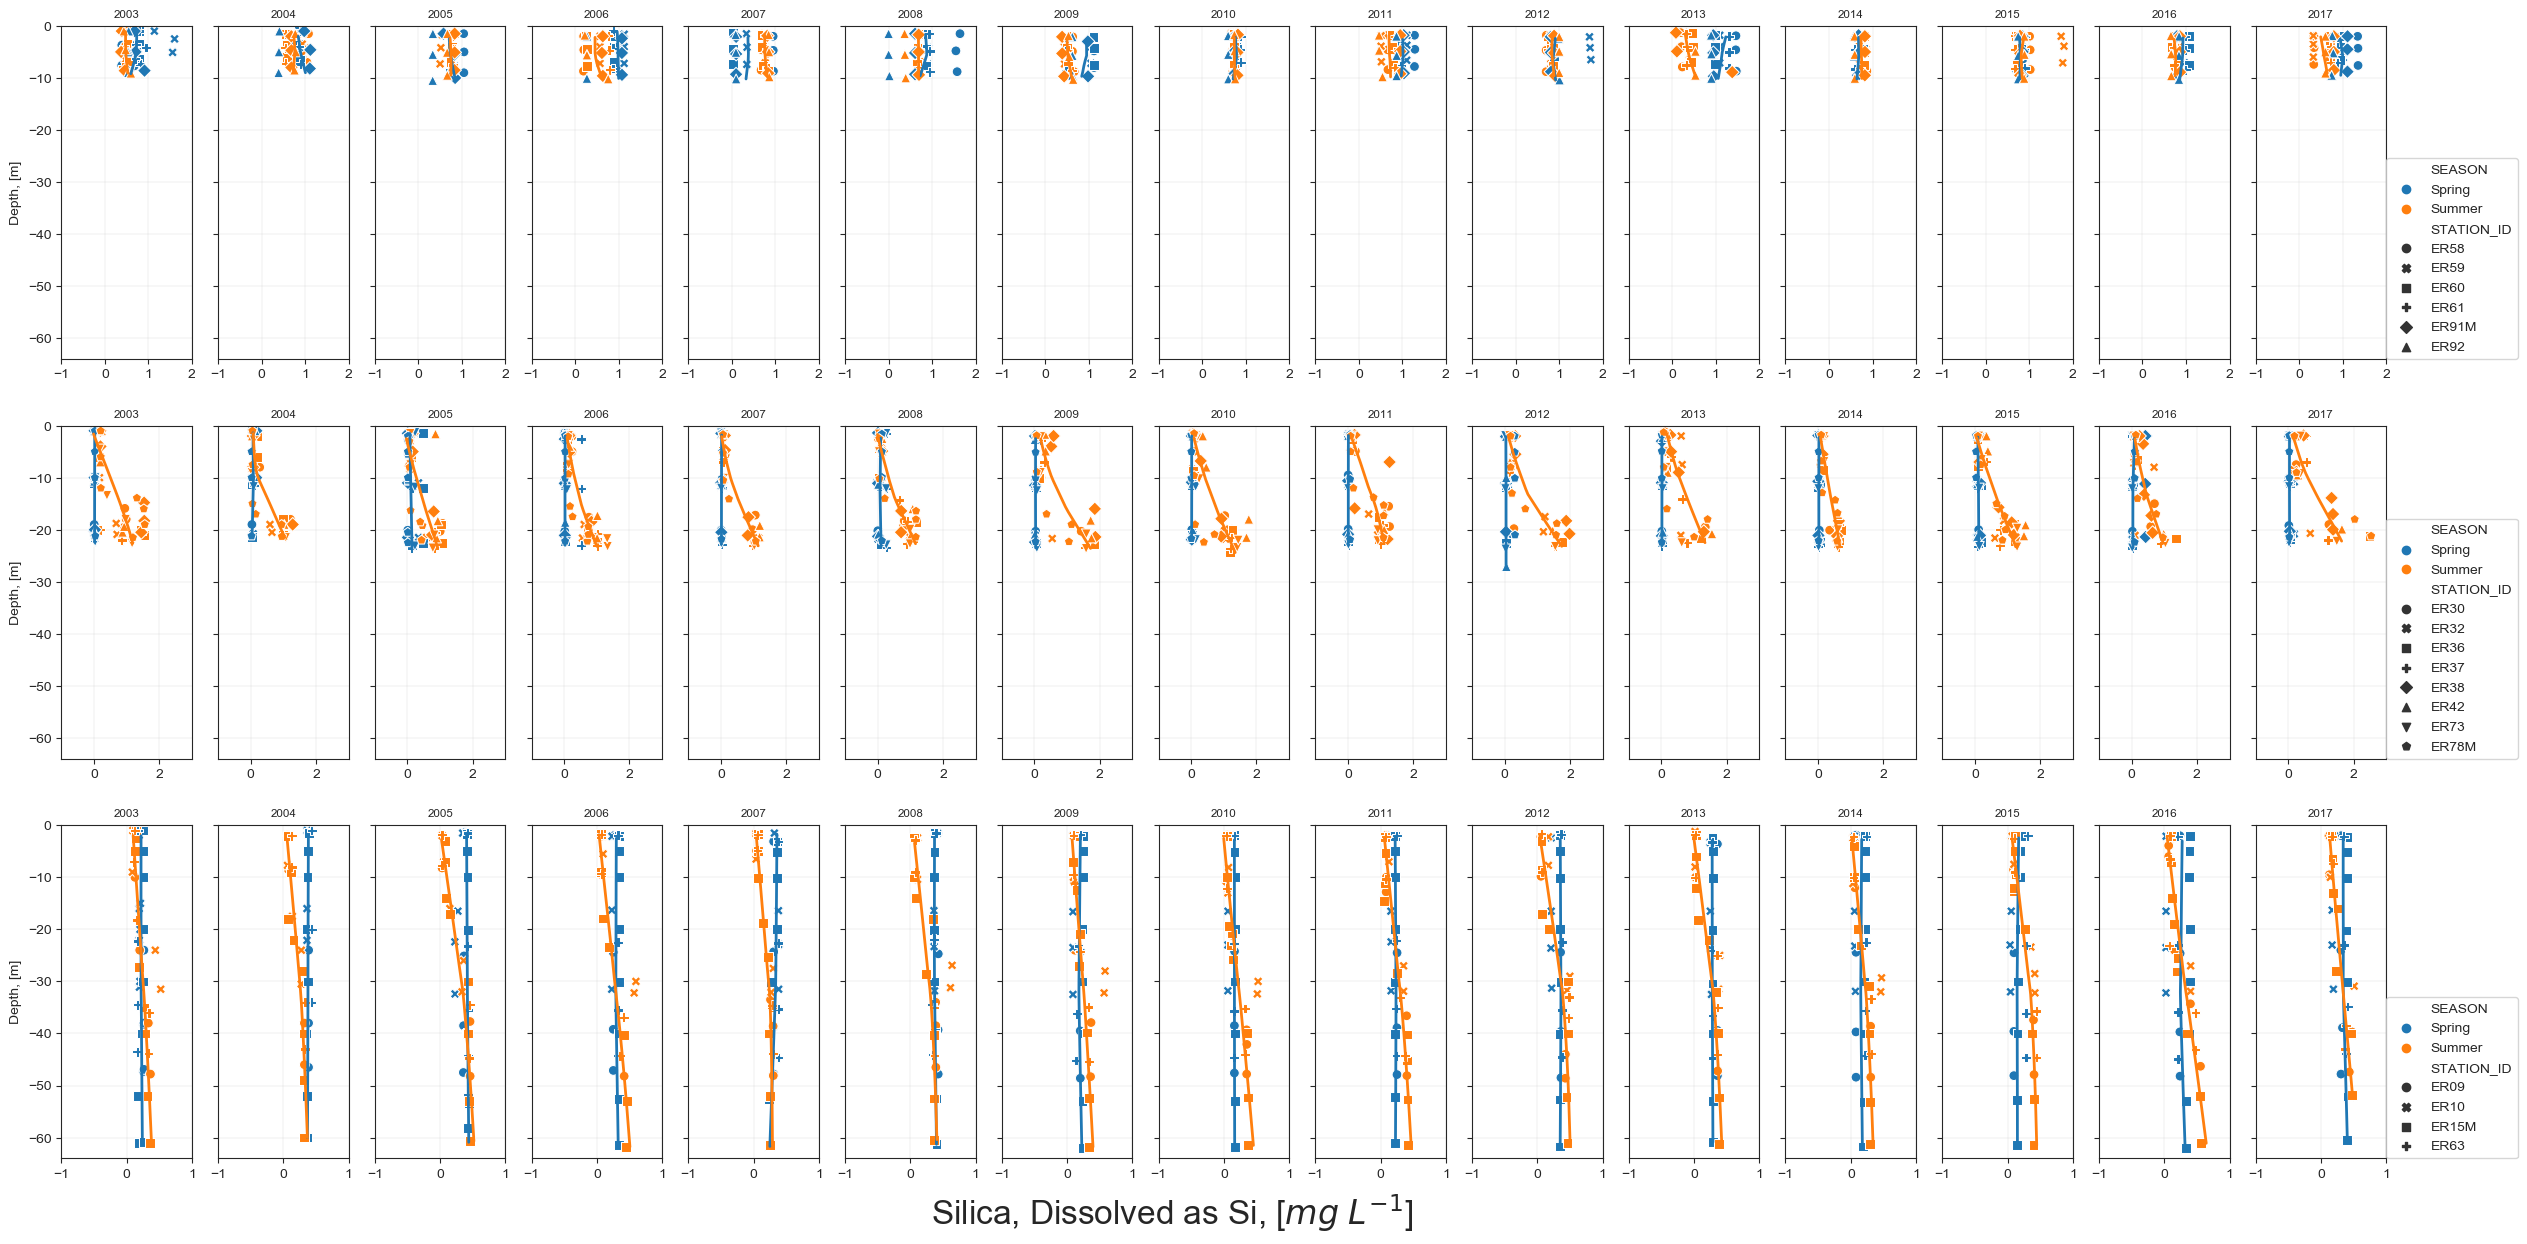

In [80]:
SilicaDissAsSi = pd.read_csv('../../measurements/GLNPO/Mass Balance/SilicaDissAsSi.csv')

SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi.QC_TYPE=='routine field sample']
SilicaDissAsSi = SilicaDissAsSi[~SilicaDissAsSi.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi.YEAR>2002]
SilicaDissAsSi.loc[:,'SAMPLE_DEPTH_M'] *= -1
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['SEASON'].isin(seasons)]
SilicaDissAsSi['VALUE_1'] = pd.to_numeric(SilicaDissAsSi['VALUE_1'], errors='coerce')
# SilicaDissAsSi = SilicaDissAsSi[SilicaDissAsSi['VALUE_1']>50]
SilicaDissAsSi = SilicaDissAsSi.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = SilicaDissAsSi[(SilicaDissAsSi['STATION_ID'].isin(b)) & (SilicaDissAsSi['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
#             axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,2)
#     axes[1][i].set_xlim(0,2)
#     axes[2][i].set_xlim(0,1)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Silica, Dissolved as Si, [$mg$ $L^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
# f.savefig('Mass Balance/GLENDA/All Stations/SilicaDissAsSi_ugL.pdf')

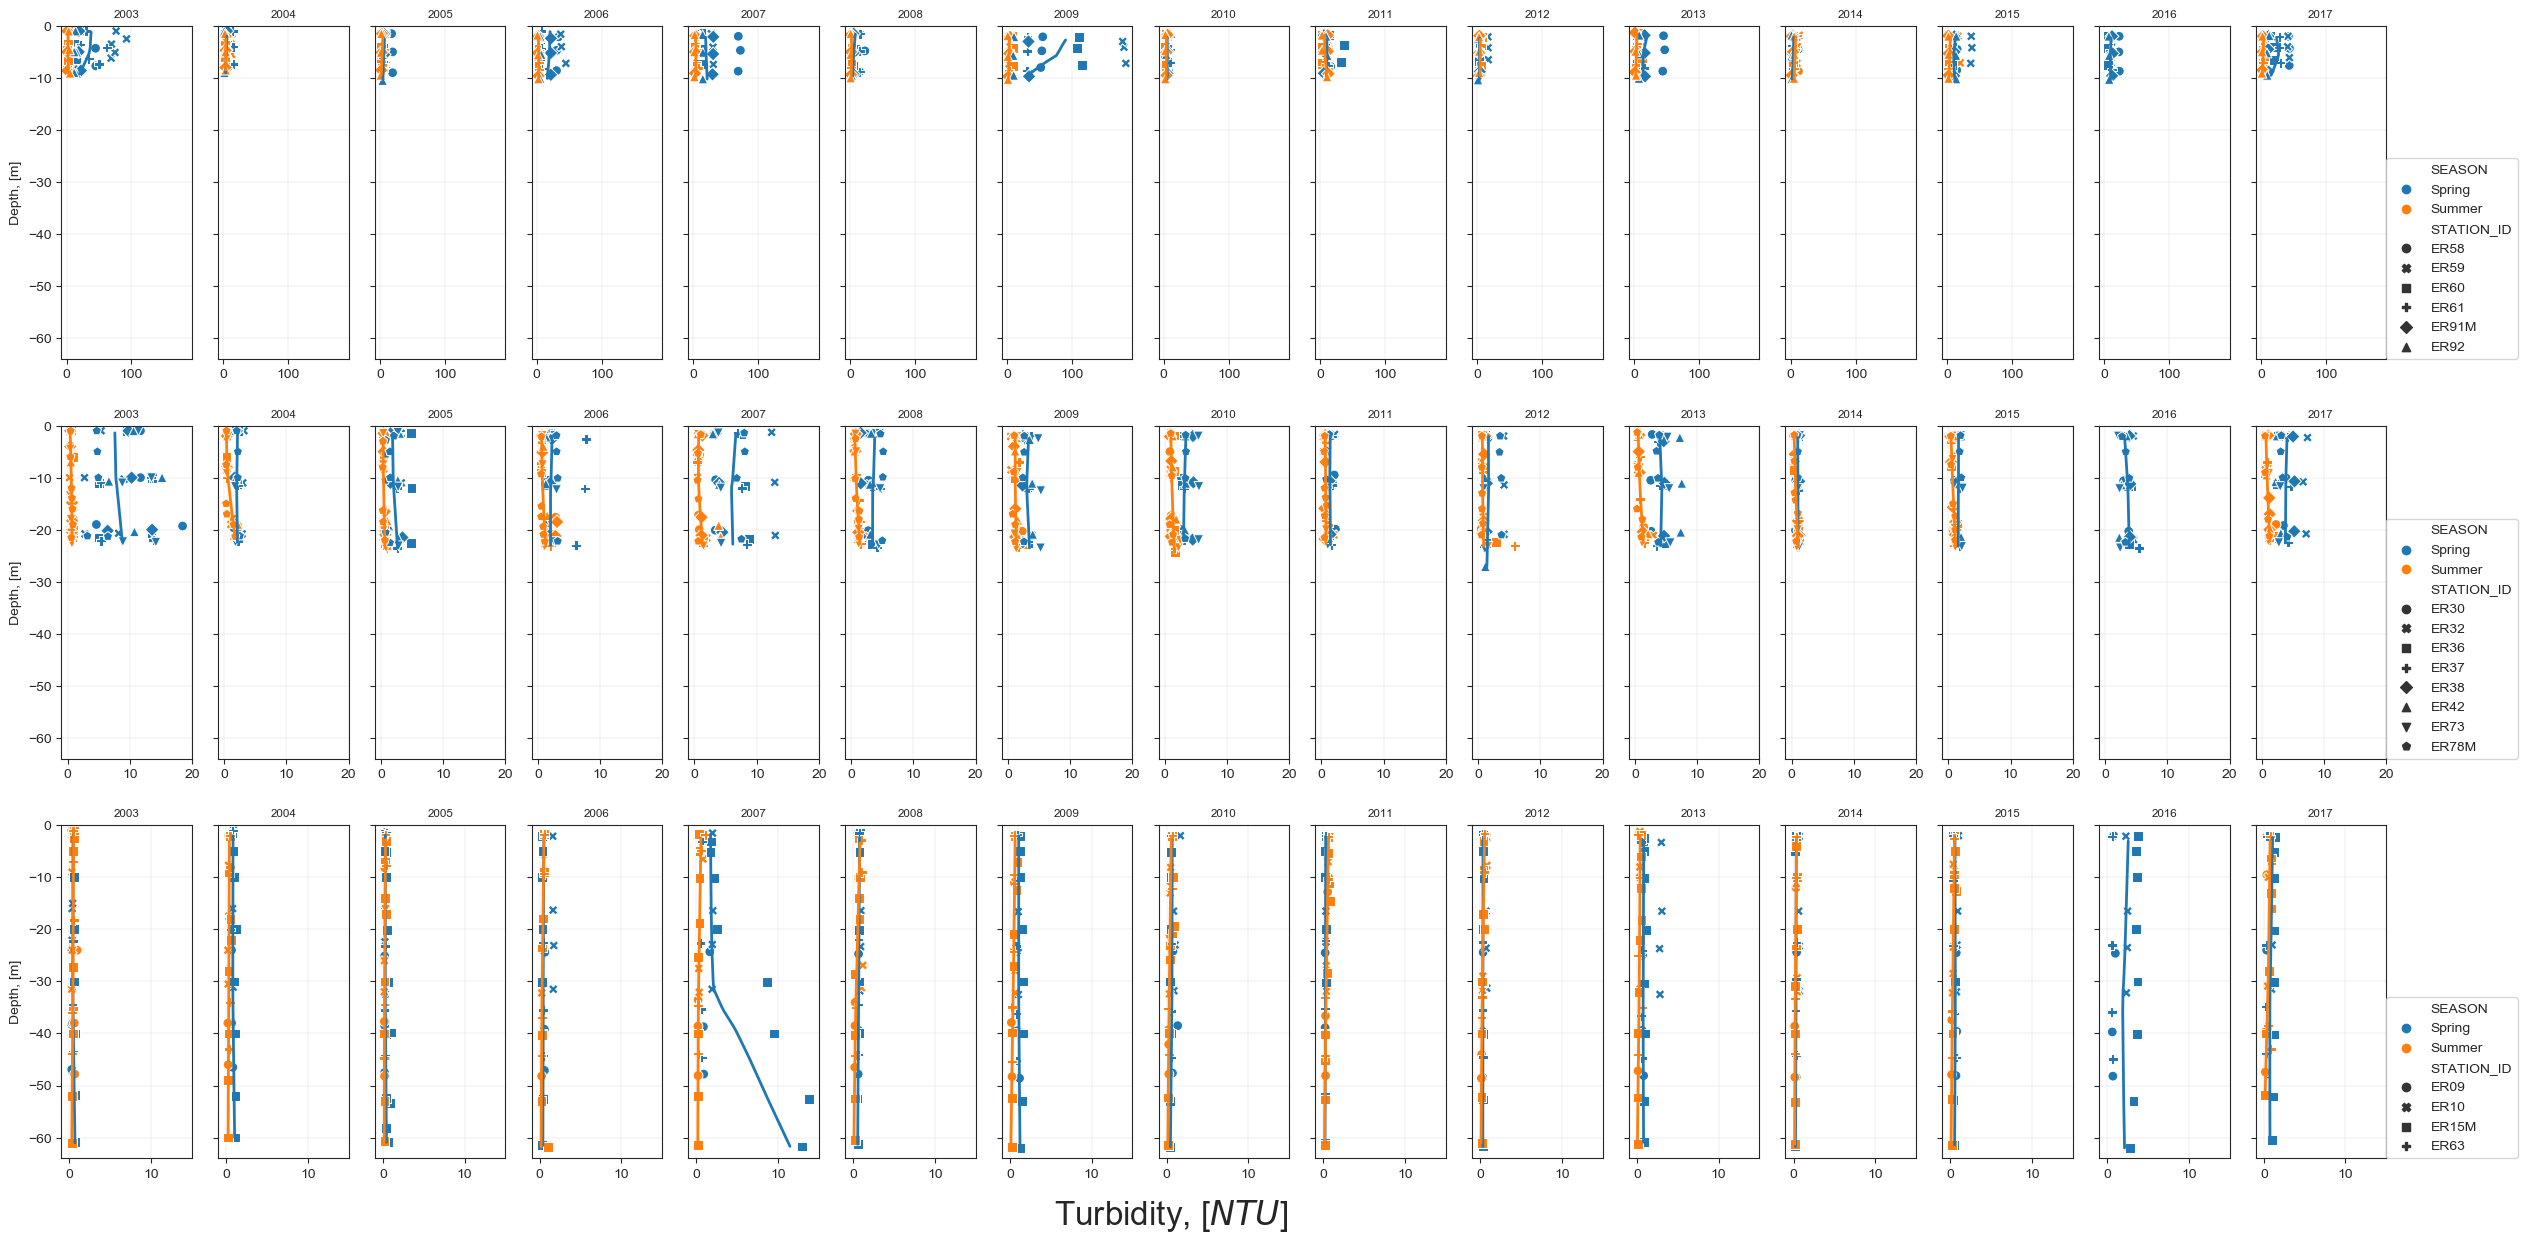

In [85]:
Turbidity = pd.read_csv('../../measurements/GLNPO/Mass Balance/Turbidity.csv')
Turbidity = Turbidity[Turbidity.QC_TYPE=='routine field sample']
Turbidity = Turbidity[~Turbidity.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Turbidity = Turbidity[Turbidity.YEAR>2002]
Turbidity.loc[:,'SAMPLE_DEPTH_M'] *= -1
Turbidity = Turbidity[Turbidity['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Turbidity = Turbidity[Turbidity['SEASON'].isin(seasons)]
Turbidity['VALUE_1'] = pd.to_numeric(Turbidity['VALUE_1'], errors='coerce')
# Turbidity = Turbidity[Turbidity['VALUE_1']>50]
Turbidity = Turbidity.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Turbidity[(Turbidity['STATION_ID'].isin(b)) & (Turbidity['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

limits = []
for line in axes:
    low = [a.get_xlim()[0] for a in line]
    high = [a.get_xlim()[1] for a in line]
    limits.append((np.floor(min(low)),np.ceil(max(high))))
    
for i,ax in enumerate(axes[0]):
    axes[0][i].set_xlim(limits[0])
    axes[1][i].set_xlim(limits[1])
    axes[2][i].set_xlim(limits[2])
# #     axes[0][i].set_xlim(0,2)
#     axes[1][i].set_xlim(0,2)
#     axes[2][i].set_xlim(0,1)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Turbidity, [$NTU$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Turbidity_NTU.pdf')

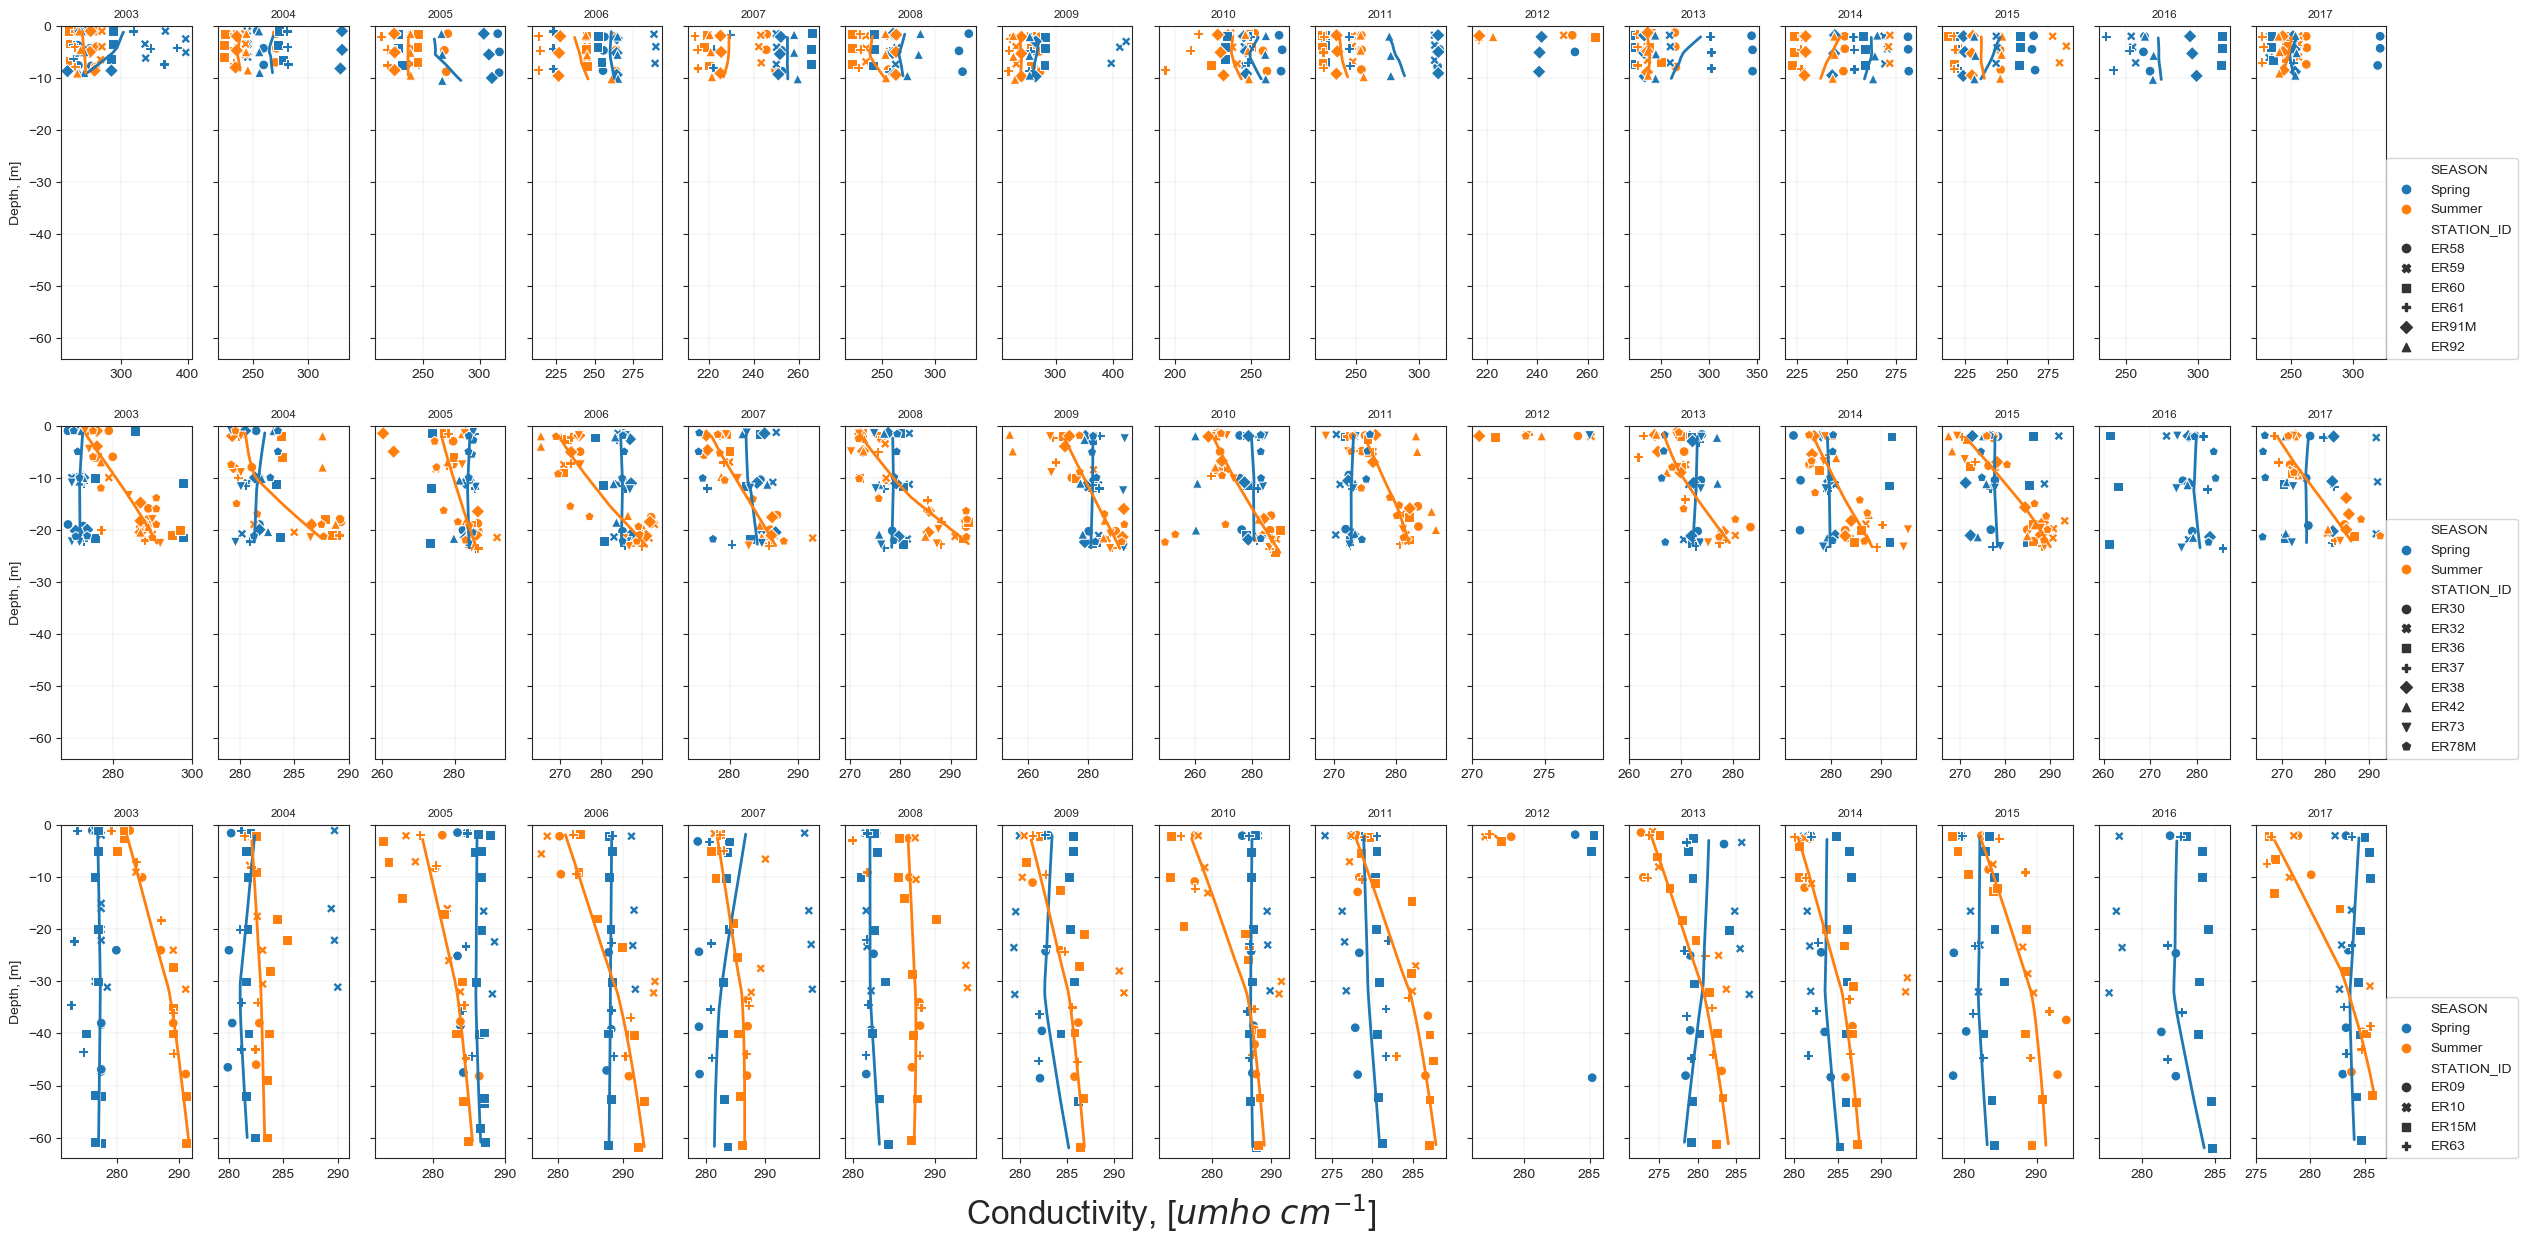

In [87]:
Conductivity = pd.read_csv('../../measurements/GLNPO/Mass Balance/Conductivity.csv')
Conductivity = Conductivity[Conductivity.QC_TYPE=='routine field sample']
Conductivity = Conductivity[~Conductivity.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
Conductivity = Conductivity[Conductivity.YEAR>2002]
Conductivity.loc[:,'SAMPLE_DEPTH_M'] *= -1
Conductivity = Conductivity[Conductivity['STATION_ID'].isin(eastern_basin + central_basin + western_basin)]
Conductivity = Conductivity[Conductivity['SEASON'].isin(seasons)]
Conductivity['VALUE_1'] = pd.to_numeric(Conductivity['VALUE_1'], errors='coerce')
# Conductivity = Conductivity[Conductivity['VALUE_1']>50]
Conductivity = Conductivity.groupby(['STATION_ID','YEAR','SEASON', 'SAMPLE_DEPTH_M']).mean()['VALUE_1'].reset_index()
f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
for j, y in enumerate(years):
    for i, b in enumerate([western_basin, central_basin, eastern_basin]):
        
        sns_data = Conductivity[(Conductivity['STATION_ID'].isin(b)) & (Conductivity['YEAR']==y)]
        sns.scatterplot(x='VALUE_1', y='SAMPLE_DEPTH_M', data=sns_data, ax=axes[i][j], hue='SEASON', style='STATION_ID', s=50)
        
        for k, s in enumerate(seasons):
            data = sns_data[sns_data['SEASON']==s]
            data = data.sort_values('SAMPLE_DEPTH_M')
            xold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['SAMPLE_DEPTH_M'].values
            yold = data.groupby('SAMPLE_DEPTH_M').mean()['VALUE_1'].reset_index()['VALUE_1'].values

            try:
                # lowess will return our "smoothed" data with a y value for at every x-value
                lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                # unpack the lowess smoothed points to their values
                lowess_x = list(zip(*lowess))[0]
                lowess_y = list(zip(*lowess))[1]


                tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                unew = np.arange(xold.min(), xold.max(), 1)
                out = tck(unew)

                if s=='Spring':
                    clr=sns.color_palette().as_hex()[0]
                if s=='Summer':
                    clr=sns.color_palette().as_hex()[1]

    #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=clr, edgecolor='w')
    #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                axes[i][j].plot(out, unew, c=clr, lw=2,zorder=10)
            except:
                pass
            axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            axes[i][j].set_ylim(-64,0)
            axes[i][j].grid(lw=0.2)
            axes[i][j].legend()
            axes[i][j].legend_.remove()
            axes[i][j].set_xlabel('')
            axes[i][j].set_ylabel('')
            axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
#             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
#                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
axes[0][14].legend(loc=(1,0))
axes[1][14].legend(loc=(1,0))
axes[2][14].legend(loc=(1,0))

# axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

# axes[2][2].set_xlim(16,18)
# axes[2][0].set_xlim(16,17.5)

# limits = []
# for line in axes:
#     low = [a.get_xlim()[0] for a in line]
#     high = [a.get_xlim()[1] for a in line]
#     limits.append((np.floor(min(low)),np.ceil(max(high))))
    
# for i,ax in enumerate(axes[0]):
#     axes[0][i].set_xlim(limits[0])
#     axes[1][i].set_xlim(limits[1])
#     axes[2][i].set_xlim(limits[2])
#     axes[0][i].set_xlim(0,2)
#     axes[1][i].set_xlim(0,2)
#     axes[2][i].set_xlim(0,1)
#     axes[2][i].set_xlim(80,100)
# #     axes[2][i].set_xlim(16,20)



axes[0][0].set_ylabel('Depth, [m]')
axes[1][0].set_ylabel('Depth, [m]')
axes[2][0].set_ylabel('Depth, [m]')
axes[2][0].text(8.5,-0.2, 'Conductivity, [$umho$ $cm^{-1}$]', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
f.savefig('Mass Balance/GLENDA/All Stations/Conductivity_umhocm_no_scale.pdf')